In [1]:
# import des librairies dont nous aurons besoin
import pandas as pd
import numpy as np

# Graphiques
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Dimensionnement de l'affichage du dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# ML
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn import dummy
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import svm
from sklearn.svm import SVR

from catboost import CatBoostRegressor
import xgboost as xgb

# Metrics
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

import timeit
import time
import pprint

import graphviz
from dtreeviz.trees import*

In [2]:
%matplotlib inline

In [3]:
# Import de fonctions de nettoyage depuis module:
from cleaning57 import na_rows_list, na_raw_drop_df, min_row_data_rate_list, min_row_data_rate_df, column_data_rate, column_data_rate_mean, columns_not_in_list, columns_delete_df, min_column_data_rate_df, low_outlier_filter_df, high_outlier_filter_df, dic_high_outlier_filter_df, word_column_filter_df, word_column_filter_lst, random_item

In [4]:
# Import de fonctions graphiques depuis module:
from plotting02 import bi_joint_plot

# CHOIX DE L'ANNEE DE PREDICTION

Le fichier a été codé pour utiliser 5 années de relevés d'énergie consécutifs. 
Dans le cas de figure actuel, les relevés d'énergie de 2015 à 2019 sont disponibles.
Les 3 premières années sont utilisées pour l'entraînement et les 2 dernières pour le test du modèle de prédiction.
le paramètre 'year' ci-dessous correspond à la 1ère année de test.

In [5]:
# year est l'année de test, ici on prendra 2018, et le fix set est construit avec les 3 années précédentes
year = '2018'

Avec les données disponibles, l'entraînement va être effectué avec les années 2015, 2016, 2017 et le test avec 2018 et 2019

In [6]:
# Bâtiments des 3 années précédentes:
year_minus_1 = str(int(year) - 1)
year_minus_2 = str(int(year) - 2)
year_minus_3 = str(int(year) - 3)


In [7]:
# Bâtiments de l'année suivante:
year_plus_1 = str(int(year) + 1)

# LECTURE DES DONNEES

In [8]:
# Le chemin des fichiers est à modifier en fonction
data = {}
for data_year in [year_minus_1,year_minus_2,year_minus_3,year,year_plus_1]:

    data[str(data_year)] = pd.read_csv(f'projets\\04_seattle_building_energy\\production\\data_seattle_building_energy_modified_{data_year}.csv',sep=',')


In [9]:
## liste float à partir des variables de 2015
float_characteristics_lst_2015 = ['DataYear','YearBuilt','YearsENERGYSTARCertified',
                                  'OSEBuildingID','TaxParcelIdentificationNumber',
                                  'CouncilDistrictCode','NumberofBuildings',
                                  'NumberofFloors','PropertyGFATotal',
                                  'PropertyGFAParking','PropertyGFABuilding(s)',
                                  'LargestPropertyUseTypeGFA',
                                  'SecondLargestPropertyUseTypeGFA',
                                  'ThirdLargestPropertyUseTypeGFA',
                                  'ENERGYSTARScore']


float_measures_lst_2015 = ['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)',
                           'SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)',
                           'SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)',
                           'SteamUse(kBtu)','Electricity(kWh)','Electricity(kBtu)',
                           'NaturalGas(therms)','NaturalGas(kBtu)',
                           'OtherFuelUse(kBtu)','GHGEmissions(MetricTonsCO2e)',
                           'GHGEmissionsIntensity(kgCO2e/ft2)']

# Adaptation des variables float en fonction de l'année de travail: 2015/2016/2017/2018/2019

float_characteristics_lst = float_characteristics_lst_2015
float_measures_lst = float_measures_lst_2015


if int(year) == 2015:
     
    data.rename({'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity', 'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions'}, axis=1, inplace=True)
    
    float_measures_lst.remove('GHGEmissionsIntensity(kgCO2e/ft2)')
    float_measures_lst.remove('GHGEmissions(MetricTonsCO2e)')
    
    float_measures_lst.append('GHGEmissionsIntensity')
    float_measures_lst.append('TotalGHGEmissions')
    
    float_measures_lst.remove('OtherFuelUse(kBtu)')
    
    
if (int(year) == 2016) | (int(year) == 2017) | (int(year) == 2018) |(int(year) == 2019):

    float_measures_lst.remove('GHGEmissionsIntensity(kgCO2e/ft2)')
    float_measures_lst.remove('GHGEmissions(MetricTonsCO2e)')
    
    float_measures_lst.append('GHGEmissionsIntensity')
    float_measures_lst.append('TotalGHGEmissions')
       
    
if (int(year) == 2018) | (int(year) == 2019):

    float_characteristics_lst.remove('YearsENERGYSTARCertified')

if (int(year) == 2019):
    float_characteristics_lst.remove('NumberofBuildings')

float_lst = float_characteristics_lst + float_measures_lst


In [10]:
data[year_minus_1].shape

(3191, 73)

In [11]:
data[year_minus_2].shape

(3211, 74)

In [12]:
data[year_minus_3]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,DefaultData,Comment,ComplianceStatus,Outlier,elec_gas_steam_otherfuel_prop,energy_type_01,energy_type_02,energy_type_03,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat,PrimaryPropertyType_new_cat_TargetEncoded,LargestPropertyUseType_new_cat,LargestPropertyUseType_new_cat_TargetEncoded,SecondLargestPropertyUseType_new_cat,SecondLargestPropertyUseType_new_cat_TargetEncoded,ThirdLargestPropertyUseType_new_cat,ThirdLargestPropertyUseType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded,PrimaryPropertyType_new_cat_<Class Missing>,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,CouncilDistrictCode_<1>,CouncilDistrictCode_<2>,CouncilDistrictCode_<3>,CouncilDistrictCode_<4>,CouncilDistrictCode_<5>,CouncilDistrictCode_<6>,CouncilDistrictCode_<7>,energy_type_02_<Class Missing>,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>
0,26379,2015,NonResidential,Hotel,GEORGETOWN INN,6.920700e+09,"6100 CORSON AVE S\nSEATTLE, WA 98108\n(47.5477...",2,GREATER DUWAMISH,1992,1,3.0,22452,Hotel,Hotel,NaN,NaN,NaN,NaN,78.0,6.131689,6.140237,1.650405,No,NaN,Compliant,NaN,"[0.435588738505571, 0.564411261494429, nan]",gas,electricity,Class Missing,6.339617,6.441550,6.426303,Medium-Low,3,Medium-Low,3,Hotel/Restaurant,6.754538,Hotel/Restaurant,6.721314,Hotel/Restaurant,6.721314,Class Missing,6.304431,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,26713,2015,Multifamily HR (10+),High-Rise Multifamily,QUINTESSA APTS,5.247801e+09,"201 YESLER WAY\nSEATTLE, WA 98104\n(47.6015502...",7,DOWNTOWN,2007,1,13.0,90959,NaN,NaN,NaN,NaN,NaN,NaN,60.0,6.639661,6.676525,2.004708,No,NaN,Compliant,NaN,"[0.6487819908516343, 0.35121800914836565, nan]",electricity,gas,Class Missing,6.339617,6.486824,6.331825,Medium-High,2,Medium-High,2,Mixed Use Property,6.225568,Class Missing,6.396836,Class Missing,6.396836,Class Missing,6.304431,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,102,2015,NonResidential,Hotel,MARRIOTT RESIDENCE INN,1.984200e+09,"800 FAIRVIEW AVE N\nSEATTLE, WA 98109\n(47.626...",3,LAKE UNION,1990,1,7.0,282863,"Hotel, Parking",Hotel,Parking,NaN,NaN,NaN,40.0,7.274830,7.303708,2.706871,No,NaN,Compliant,NaN,"[0.5650038697094608, 0.43499613029053913, nan]",electricity,gas,Class Missing,6.339617,6.486824,6.331825,Highest Use,0,Highest Use,0,Hotel/Restaurant,6.754538,Hotel/Restaurant,6.721314,Hotel/Restaurant,6.721314,Class Missing,6.304431,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,503,2015,NonResidential,Supermarket/Grocery Store,RESTAURANT DEPOT,1.824049e+09,"3670 E MARGINAL WAY S\nSEATTLE, WA 98134\n(47....",2,GREATER DUWAMISH,2008,1,1.0,63225,Supermarket/Grocery Store,Supermarket/Grocery Store,NaN,NaN,NaN,NaN,100.0,6.820854,6.820854,1.664172,No,NaN,Compliant,NaN,"[1.0, nan, nan]",electricity,Class Missing,Class Missing,6.339617,6.112639,6.331825,Medium-High,2,Medium-High,2

In [13]:
data[year].shape

(3112, 70)

In [14]:
data[year_plus_1].shape

(3268, 70)

# CREATION DU "FIX SET"

La condition d'entrée d'un bâtiment dans le fix set est le fait d'avoir 3 années de relevés d'énergie consécutifs (le nettoyage outlier a été effectué précédemment)

In [15]:
list_0 = list(data[year]['OSEBuildingID'].unique())
len(list_0)

3112

In [16]:
# Rappel du nombre de lignes du dataset 
data[year].shape

(3112, 70)

In [17]:
# Liste des bâtiments dans le fix dataset des 3 dernières années avant l'année 'year' prédite:
fix_lst_base = []

list_minus_1 = list(data[year_minus_1]['OSEBuildingID'].unique())
list_minus_2 = list(data[year_minus_2]['OSEBuildingID'].unique())
list_minus_3 = list(data[year_minus_3]['OSEBuildingID'].unique())

for building in list_0:
    if (
        (building in list_minus_1) and 
        (building in list_minus_2) and 
        (building in list_minus_3)):
        fix_lst_base.append(building)
len(fix_lst_base)

2555

In [18]:
# Filtre fix set sur l'année en cours:

data_year_fix_set = data[year][data[year]['OSEBuildingID'].isin(fix_lst_base)]
data_year_fix_set.shape

(2555, 70)

In [19]:
# Filtre fix set sur l'année -1:

data_year_minus_1_fix_set = data[year_minus_1][data[year_minus_1]['OSEBuildingID'].isin(fix_lst_base)]
data_year_minus_1_fix_set.shape

(2555, 73)

In [20]:
# Filtre fix set sur l'année -2:

data_year_minus_2_fix_set = data[year_minus_2][data[year_minus_2]['OSEBuildingID'].isin(fix_lst_base)]
data_year_minus_2_fix_set.shape

(2555, 74)

In [21]:
# Filtre fix set sur l'année -3:

data_year_minus_3_fix_set = data[year_minus_3][data[year_minus_3]['OSEBuildingID'].isin(fix_lst_base)]
data_year_minus_3_fix_set.shape

(2555, 69)

In [22]:
# Filtre fix set sur l'année +1:
data_year_plus_1_fix_set = data[year_plus_1][data[year_plus_1]['OSEBuildingID'].isin(fix_lst_base)]
data_year_plus_1_fix_set.shape

(2463, 70)

In [23]:
# Création d'un dictionnaire data fix set avec l'année en cours et les 3 années précédentes

data_fix_set = {}
for data_year in [year_minus_3, year_minus_2, year_minus_1, year, year_plus_1]:

    if data_year == year_minus_3:
        data_fix_set[str(data_year)] = data_year_minus_3_fix_set.copy()
    
    if data_year == year_minus_2:
        data_fix_set[str(data_year)] = data_year_minus_2_fix_set.copy()
        
    if data_year == year_minus_1:
        data_fix_set[str(data_year)] = data_year_minus_1_fix_set.copy()
        
    if data_year == year:
        data_fix_set[str(data_year)] = data_year_fix_set.copy()
        
    if data_year == year_plus_1:
        data_fix_set[str(data_year)] = data_year_plus_1_fix_set.copy()
        
    

In [24]:
data_fix_set[year_plus_1]

,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,Longitude,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofFloors,PropertyGFATotal,PrimaryPropertyType,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,EPAPropertyType,ComplianceStatus,ComplianceIssue,TotalGHGEmissions,elec_gas_steam_otherfuel_prop,energy_type_01,energy_type_02,energy_type_03,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat,PrimaryPropertyType_new_cat_TargetEncoded,LargestPropertyUseType_new_cat,LargestPropertyUseType_new_cat_TargetEncoded,SecondLargestPropertyUseType_new_cat,SecondLargestPropertyUseType_new_cat_TargetEncoded,ThirdLargestPropertyUseType_new_cat,ThirdLargestPropertyUseType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded,PrimaryPropertyType_new_cat_<Class Missing>,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,CouncilDistrictCode_<1>,CouncilDistrictCode_<2>,CouncilDistrictCode_<3>,CouncilDistrictCode_<4>,CouncilDistrictCode_<5>,CouncilDistrictCode_<6>,CouncilDistrictCode_<7>,energy_type_02_<Class Missing>,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>
0,1,2019,MAYFLOWER PARK HOTEL,NonResidential,6.590000e+08,405 OLIVE WAY,SEATTLE,WA,98101.0,47.61220,-122.33799,DOWNTOWN,1.0,1927,12.0,88434,Hotel,62.0,6.867068,6.866397,Hotel,NaN,NaN,NaN,Hotel,Compliant,No Issue,2.319730,"[0.5266685392073984, 0.17965387014043374, 0.29...",electricity,steam,gas,7.135652,7.037727,6.335620,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.793199,Hotel/Restaurant,6.802314,Hotel/Restaurant,6.802314,Class Missing,6.298566,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,2019,PARAMOUNT HOTEL,NonResidential,6.590002e+08,724 PINE ST,SEATTLE,WA,98101.0,47.61317,-122.33393,DOWNTOWN,1.0,1996,11.0,103566,Hotel,70.0,6.905291,6.903438,Hotel,Parking,Restaurant,4622.0,Hotel,Compliant,No Issue,2.457731,"[0.3680681114767628, 0.6319318885232371, nan]",gas,electricity,Class Missing,6.351603,6.476582,6.449407,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.793199,Hotel/Restaurant,6.802314,Hotel/Restaurant,6.802314,Hotel/Restaurant,6.705250,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,2019,WESTIN HOTEL (Parent Building),NonResidential,6.590005e+08,1900 5TH AVE,SEATTLE,WA,98101.0,47.61367,-122.33822,DOWNTOWN,1.0,1969,41.0,956110,Hotel,64.0,7.834774,7.833168,Hotel,Parking,Swimming Pool,NaN,Hotel,Compliant,No Issue,3.190051,"[0.6471913057325519, 0.02094466395994377, 0.33...",electricity,steam,gas,7.135652,7.037727,6.335620,Highest Use,0,Highest Use,0,Hotel/Restaurant,6.793199,Hotel/Restaurant,6.802314,Hotel/Restaurant,6.802314,Other/Public places,6.714744,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8,2019,WARWICK SEATTLE HOTEL,NonResidential,6.590010e+08,401 LENORA ST,SEATTLE,WA,98121.0,47.61375,-122.34047,DOWNTOWN,1.0,1980,18.0,175580,Hotel,63.0,7.200717,7.200717,Hotel,Parking,Swimming Pool,NaN,Hotel,Compliant,No Issue,2.769008,"[0.34297816071412934, 0.6570218392858707, nan]",gas,electricity,Class Missing,6.351603,6.476582,6.449407,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.793199,Hotel/Restaurant,6.802314,Hotel/Restaurant,6.80

In [25]:
data_fix_set[year]

,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,Longitude,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofFloors,NumberofBuildings,PropertyGFATotal,PrimaryPropertyType,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,TotalGHGEmissions,ComplianceStatus,ComplianceIssue,elec_gas_steam_otherfuel_prop,energy_type_01,energy_type_02,energy_type_03,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat,PrimaryPropertyType_new_cat_TargetEncoded,LargestPropertyUseType_new_cat,LargestPropertyUseType_new_cat_TargetEncoded,SecondLargestPropertyUseType_new_cat,SecondLargestPropertyUseType_new_cat_TargetEncoded,ThirdLargestPropertyUseType_new_cat,ThirdLargestPropertyUseType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded,PrimaryPropertyType_new_cat_<Class Missing>,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,CouncilDistrictCode_<1>,CouncilDistrictCode_<2>,CouncilDistrictCode_<3>,CouncilDistrictCode_<4>,CouncilDistrictCode_<5>,CouncilDistrictCode_<6>,CouncilDistrictCode_<7>,energy_type_02_<Class Missing>,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>
0,1,2018,MAYFLOWER PARK HOTEL,NonResidential,6.590000e+08,405 OLIVE WAY,SEATTLE,WA,98101.0,47.61220,-122.33799,DOWNTOWN,1.0,1927,12.0,NaN,88434,Hotel,60.0,6.873087,6.869718,Hotel,NaN,NaN,NaN,2.293141,Compliant,No Issue,"[0.5275106033255452, 0.19034692086121371, 0.28...",electricity,steam,gas,7.154393,7.142563,6.341096,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.749175,Hotel/Restaurant,6.764679,Hotel/Restaurant,6.764679,Class Missing,6.301396,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,2018,PARAMOUNT HOTEL,NonResidential,6.590002e+08,724 PINE ST,SEATTLE,WA,98101.0,47.61317,-122.33393,DOWNTOWN,1.0,1996,11.0,1.0,103566,Hotel,71.0,6.901075,6.897481,Hotel,Parking,Restaurant,4622.0,2.439017,Compliant,No Issue,"[0.36298464863824487, 0.6370153513617551, nan]",gas,electricity,Class Missing,6.350765,6.459307,6.425118,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.749175,Hotel/Restaurant,6.764679,Hotel/Restaurant,6.764679,Hotel/Restaurant,6.687317,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,2018,WESTIN HOTEL (Parent Building),NonResidential,6.590005e+08,1900 5TH AVE,SEATTLE,WA,98101.0,47.61393,-122.33810,DOWNTOWN,1.0,1969,41.0,3.0,956110,Hotel,64.0,7.828250,7.824487,Hotel,Parking,Swimming Pool,NaN,3.115344,Compliant,No Issue,"[0.6659169412268634, 0.021725534756668694, 0.3...",electricity,steam,gas,7.154393,7.142563,6.341096,Highest Use,0,Highest Use,0,Hotel/Restaurant,6.749175,Hotel/Restaurant,6.764679,Hotel/Restaurant,6.764679,Other/Public places,6.702652,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8,2018,WARWICK SEATTLE HOTEL,NonResidential,6.590010e+08,401 LENORA ST,SEATTLE,WA,98121.0,47.61375,-122.34047,DOWNTOWN,1.0,1980,18.0,NaN,175580,Hotel,81.0,7.122606,7.118400,Hotel,Parking,Swimming Pool,NaN,2.660771,Compliant,No Issue,"[0.3617442237169748, 0.6382557762830252, nan]",gas,electricity,Class Missing,6.350765,6.459307,6.425118,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.749175,Hotel/Restaurant,6.764679,Hotel/Restaurant,6.764679,O

In [26]:
data_fix_set[year_minus_1]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,DefaultData,ComplianceStatus,Outlier,elec_gas_steam_otherfuel_prop,energy_type_01,energy_type_02,energy_type_03,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat,PrimaryPropertyType_new_cat_TargetEncoded,LargestPropertyUseType_new_cat,LargestPropertyUseType_new_cat_TargetEncoded,SecondLargestPropertyUseType_new_cat,SecondLargestPropertyUseType_new_cat_TargetEncoded,ThirdLargestPropertyUseType_new_cat,ThirdLargestPropertyUseType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded,PrimaryPropertyType_new_cat_<Class Missing>,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,CouncilDistrictCode_<1>,CouncilDistrictCode_<2>,CouncilDistrictCode_<3>,CouncilDistrictCode_<4>,CouncilDistrictCode_<5>,CouncilDistrictCode_<6>,CouncilDistrictCode_<7>,energy_type_02_<Class Missing>,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>
0,1,2017,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,6.590000e+08,7.0,DOWNTOWN,47.61220,-122.33799,1927.0,1.0,12.0,88434,Hotel,Hotel,NaN,NaN,NaN,NaN,63.0,6.866975,6.861800,2.295853,N,Compliant,NaN,"[0.5366125076420276, 0.17502355537825318, 0.28...",electricity,steam,gas,7.091162,7.073360,6.331790,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.859677,Hotel/Restaurant,6.712027,Hotel/Restaurant,6.712027,Class Missing,6.303633,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2,2017,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,6.590002e+08,7.0,DOWNTOWN,47.61317,-122.33393,1996.0,1.0,11.0,103566,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,4622.0,NaN,72.0,6.892364,6.885294,2.426153,N,Compliant,NaN,"[0.3865237167970003, 0.6134762832029997, nan]",gas,electricity,Class Missing,6.342457,6.448662,6.421342,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.859677,Hotel/Restaurant,6.712027,Hotel/Restaurant,6.712027,Hotel/Restaurant,6.677640,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3,2017,Campus,Hotel,84SC9-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,6.590005e+08,7.0,DOWNTOWN,47.61393,-122.33810,1969.0,1.0,41.0,956110,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,NaN,NaN,48.0,7.871983,7.871055,3.196107,N,Compliant,NaN,"[0.6541242055146709, 0.01939027579968287, 0.32...",electricity,steam,gas,7.091162,7.073360,6.331790,Highest Use,0,Highest Use,0,Hotel/Restaurant,6.859677,Hotel/Restaurant,6.712027,Hotel/Restaurant,6.712027,Other/Public places,6.723122,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,8,2017,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,6.590010e+08,7.0,DOWNTOWN,47.61375,-122.34047,1980.0,1.0,18.0,175580,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,NaN,NaN,78.0,7.156421,7.148641,2.704837,N,Compliant,NaN,"[0.36260339947539943, 0.6373966005246005, nan]"

In [27]:
data_fix_set[year_minus_2]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,elec_gas_steam_otherfuel_prop,energy_type_01,energy_type_02,energy_type_03,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat,PrimaryPropertyType_new_cat_TargetEncoded,LargestPropertyUseType_new_cat,LargestPropertyUseType_new_cat_TargetEncoded,SecondLargestPropertyUseType_new_cat,SecondLargestPropertyUseType_new_cat_TargetEncoded,ThirdLargestPropertyUseType_new_cat,ThirdLargestPropertyUseType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded,PrimaryPropertyType_new_cat_<Class Missing>,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,CouncilDistrictCode_<1>,CouncilDistrictCode_<2>,CouncilDistrictCode_<3>,CouncilDistrictCode_<4>,CouncilDistrictCode_<5>,CouncilDistrictCode_<6>,CouncilDistrictCode_<7>,energy_type_02_<Class Missing>,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,6.590000e+08,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12.0,88434,Hotel,Hotel,NaN,NaN,NaN,NaN,60.0,6.858920,6.872559,False,NaN,Compliant,NaN,2.397905,"[0.546059967657308, 0.1766383970246716, 0.2773...",electricity,steam,gas,7.059833,7.006973,6.337084,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.886444,Hotel/Restaurant,6.738145,Hotel/Restaurant,6.738145,Class Missing,6.304286,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,6.590002e+08,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11.0,103566,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,4622.0,NaN,61.0,6.923655,6.937742,False,NaN,Compliant,NaN,2.471086,"[0.38660907281925116, 0.6133909271807488, nan]",gas,electricity,Class Missing,6.345059,6.449379,6.435758,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.886444,Hotel/Restaurant,6.738145,Hotel/Restaurant,6.738145,Hotel/Restaurant,6.658278,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,6.590005e+08,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41.0,956110,Hotel,Hotel,NaN,NaN,NaN,NaN,43.0,7.860859,7.868862,False,NaN,Compliant,NaN,3.319997,"[0.6823074616455521, 0.020579437496660906, 0.2...",electricity,steam,gas,7.059833,7.006973,6.337084,Highest Use,0,Highest Use,0,Hotel/Restaurant,6.886444,Hotel/Restaurant,6.738145,Hotel/Restaurant,6.738145,Class Missing,6.304286,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,6.590010e+08,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18.0,175580,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,NaN,NaN,75.0,7.151450,7.166030,False,NaN,Compliant,NaN,2.703300,"[0.3788017093540672, 0.6211982906459328, nan]",gas,electricity,Cla

In [28]:
data_fix_set[year_minus_3]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,DefaultData,Comment,ComplianceStatus,Outlier,elec_gas_steam_otherfuel_prop,energy_type_01,energy_type_02,energy_type_03,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat,PrimaryPropertyType_new_cat_TargetEncoded,LargestPropertyUseType_new_cat,LargestPropertyUseType_new_cat_TargetEncoded,SecondLargestPropertyUseType_new_cat,SecondLargestPropertyUseType_new_cat_TargetEncoded,ThirdLargestPropertyUseType_new_cat,ThirdLargestPropertyUseType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded,PrimaryPropertyType_new_cat_<Class Missing>,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,CouncilDistrictCode_<1>,CouncilDistrictCode_<2>,CouncilDistrictCode_<3>,CouncilDistrictCode_<4>,CouncilDistrictCode_<5>,CouncilDistrictCode_<6>,CouncilDistrictCode_<7>,energy_type_02_<Class Missing>,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>
0,26379,2015,NonResidential,Hotel,GEORGETOWN INN,6.920700e+09,"6100 CORSON AVE S\nSEATTLE, WA 98108\n(47.5477...",2,GREATER DUWAMISH,1992,1,3.0,22452,Hotel,Hotel,NaN,NaN,NaN,NaN,78.0,6.131689,6.140237,1.650405,No,NaN,Compliant,NaN,"[0.435588738505571, 0.564411261494429, nan]",gas,electricity,Class Missing,6.339617,6.441550,6.426303,Medium-Low,3,Medium-Low,3,Hotel/Restaurant,6.754538,Hotel/Restaurant,6.721314,Hotel/Restaurant,6.721314,Class Missing,6.304431,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,26713,2015,Multifamily HR (10+),High-Rise Multifamily,QUINTESSA APTS,5.247801e+09,"201 YESLER WAY\nSEATTLE, WA 98104\n(47.6015502...",7,DOWNTOWN,2007,1,13.0,90959,NaN,NaN,NaN,NaN,NaN,NaN,60.0,6.639661,6.676525,2.004708,No,NaN,Compliant,NaN,"[0.6487819908516343, 0.35121800914836565, nan]",electricity,gas,Class Missing,6.339617,6.486824,6.331825,Medium-High,2,Medium-High,2,Mixed Use Property,6.225568,Class Missing,6.396836,Class Missing,6.396836,Class Missing,6.304431,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,102,2015,NonResidential,Hotel,MARRIOTT RESIDENCE INN,1.984200e+09,"800 FAIRVIEW AVE N\nSEATTLE, WA 98109\n(47.626...",3,LAKE UNION,1990,1,7.0,282863,"Hotel, Parking",Hotel,Parking,NaN,NaN,NaN,40.0,7.274830,7.303708,2.706871,No,NaN,Compliant,NaN,"[0.5650038697094608, 0.43499613029053913, nan]",electricity,gas,Class Missing,6.339617,6.486824,6.331825,Highest Use,0,Highest Use,0,Hotel/Restaurant,6.754538,Hotel/Restaurant,6.721314,Hotel/Restaurant,6.721314,Class Missing,6.304431,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,225,2015,SPS-District K-12,K-12 School,DENNY/ SEALTH CAMPUS (SPS-DISTRICT),3.624039e+09,"2500 SW THISTLE ST\nSEATTLE, WA 98106\n(47.529...",1,DELRIDGE,2010,1,2.0,367884,K-12 School,K-12 School,NaN,NaN,NaN,2016.0,93.0,7.088621,7.157040,2.433482,No,NaN,Compliant,NaN,"[0.6715924269259311, 0.32840757307406887, nan]",electricity,gas,Class Missing,6.339617,6.486824,6.331825,Medium-High,2,Medium-High,2,Edu

# CREATION DATASET ENTRAINEMENT/VALIDATION

Pour rappel l'année à prédire est: year = '2018'

## Concaténation des dataset "fix set" year_minus_1/year_minus_2/year_minus_3 modifiés

In [29]:
data_fix_set_train_val = pd.concat([data_fix_set[year_minus_1], data_fix_set[year_minus_2], data_fix_set[year_minus_3]])
data_fix_set_train_val.shape

(7665, 76)

In [30]:
data_fix_set_train_val.duplicated().value_counts()

False    7665
dtype: int64

In [31]:
data_fix_set_train_val

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,DefaultData,ComplianceStatus,Outlier,elec_gas_steam_otherfuel_prop,energy_type_01,energy_type_02,energy_type_03,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat,PrimaryPropertyType_new_cat_TargetEncoded,LargestPropertyUseType_new_cat,LargestPropertyUseType_new_cat_TargetEncoded,SecondLargestPropertyUseType_new_cat,SecondLargestPropertyUseType_new_cat_TargetEncoded,ThirdLargestPropertyUseType_new_cat,ThirdLargestPropertyUseType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded,PrimaryPropertyType_new_cat_<Class Missing>,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,CouncilDistrictCode_<1>,CouncilDistrictCode_<2>,CouncilDistrictCode_<3>,CouncilDistrictCode_<4>,CouncilDistrictCode_<5>,CouncilDistrictCode_<6>,CouncilDistrictCode_<7>,energy_type_02_<Class Missing>,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>,Comments,Location,Comment
0,1,2017,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,6.590000e+08,7.0,DOWNTOWN,47.61220,-122.33799,1927.0,1.0,12.0,88434,Hotel,Hotel,NaN,NaN,NaN,NaN,63.0,6.866975,6.861800,2.295853,N,Compliant,NaN,"[0.5366125076420276, 0.17502355537825318, 0.28...",electricity,steam,gas,7.091162,7.073360,6.331790,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.859677,Hotel/Restaurant,6.712027,Hotel/Restaurant,6.712027,Class Missing,6.303633,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
1,2,2017,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,6.590002e+08,7.0,DOWNTOWN,47.61317,-122.33393,1996.0,1.0,11.0,103566,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,4622.0,NaN,72.0,6.892364,6.885294,2.426153,N,Compliant,NaN,"[0.3865237167970003, 0.6134762832029997, nan]",gas,electricity,Class Missing,6.342457,6.448662,6.421342,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.859677,Hotel/Restaurant,6.712027,Hotel/Restaurant,6.712027,Hotel/Restaurant,6.677640,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN
2,3,2017,Campus,Hotel,84SC9-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,6.590005e+08,7.0,DOWNTOWN,47.61393,-122.33810,1969.0,1.0,41.0,956110,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,NaN,NaN,48.0,7.871983,7.871055,3.196107,N,Compliant,NaN,"[0.6541242055146709, 0.01939027579968287, 0.32...",electricity,steam,gas,7.091162,7.073360,6.331790,Highest Use,0,Highest Use,0,Hotel/Restaurant,6.859677,Hotel/Restaurant,6.712027,Hotel/Restaurant,6.712027,Other/Public places,6.723122,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
4,8,2017,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,6.590010e+08,7.0,DOWNTOWN,47.61375,-122.34047,1980.0,1.0,18.0,175580,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,NaN,NaN,78.0,7.156421,7.148641,2.704837,N,

## Tirage aléatoire de bâtiments sur plusieurs années

In [32]:
data_fix_set_train_val.reset_index(drop=True, inplace=True)
data_fix_set_train_val.shape

(7665, 76)

In [33]:
# Un bâtiment apparaît sur plusieurs années, on effectue donc un tirage aléatoire
data_fix_set_train_val_random = random_item(data_fix_set_train_val, 'OSEBuildingID')
data_fix_set_train_val_random

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,DefaultData,ComplianceStatus,Outlier,elec_gas_steam_otherfuel_prop,energy_type_01,energy_type_02,energy_type_03,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat,PrimaryPropertyType_new_cat_TargetEncoded,LargestPropertyUseType_new_cat,LargestPropertyUseType_new_cat_TargetEncoded,SecondLargestPropertyUseType_new_cat,SecondLargestPropertyUseType_new_cat_TargetEncoded,ThirdLargestPropertyUseType_new_cat,ThirdLargestPropertyUseType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded,PrimaryPropertyType_new_cat_<Class Missing>,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,CouncilDistrictCode_<1>,CouncilDistrictCode_<2>,CouncilDistrictCode_<3>,CouncilDistrictCode_<4>,CouncilDistrictCode_<5>,CouncilDistrictCode_<6>,CouncilDistrictCode_<7>,energy_type_02_<Class Missing>,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>,Comments,Location,Comment
5298,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,NaN,NaN,NaN,NaN,6.590000e+08,7.0,DOWNTOWN,NaN,NaN,1927.0,1.0,12.0,88434,Hotel,Hotel,NaN,NaN,NaN,NaN,65.0,6.843944,6.851108,2.396949,No,Compliant,NaN,"[0.5279836369417811, 0.1822492902752672, 0.289...",electricity,steam,gas,6.972809,6.986714,6.331825,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.754538,Hotel/Restaurant,6.721314,Hotel/Restaurant,6.721314,Class Missing,6.304431,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,"405 OLIVE WAY\nSEATTLE, WA 98101\n(47.61219025...",NaN
1,2,2017,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,6.590002e+08,7.0,DOWNTOWN,47.61317,-122.33393,1996.0,1.0,11.0,103566,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,4622.0,NaN,72.0,6.892364,6.885294,2.426153,N,Compliant,NaN,"[0.3865237167970003, 0.6134762832029997, nan]",gas,electricity,Class Missing,6.342457,6.448662,6.421342,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.859677,Hotel/Restaurant,6.712027,Hotel/Restaurant,6.712027,Hotel/Restaurant,6.677640,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN
2557,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,6.590005e+08,7.0,DOWNTOWN,47.61393,-122.33810,1969.0,1.0,41.0,956110,Hotel,Hotel,NaN,NaN,NaN,NaN,43.0,7.860859,7.868862,3.319997,False,Compliant,NaN,"[0.6823074616455521, 0.020579437496660906, 0.2...",electricity,steam,gas,7.059833,7.006973,6.337084,Highest Use,0,Highest Use,0,Hotel/Restaurant,6.886444,Hotel/Restaurant,6.738145,Hotel/Restaurant,6.738145,Class Missing,6.304286,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
5215,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,NaN,NaN,NaN,NaN,6.590010e+08,7.0,DOWNTOWN,NaN,NaN,1980.0,1.0,18.0,119890,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,NaN,NaN,67.0,7.171115,7.178351,2.705607,No,Compliant,NaN,"[0.40907018851129684, 0.5

In [34]:
# Vérification du taux de remplissage par colonne
column_data_rate(data_fix_set_train_val_random)

OSEBuildingID                                                  1.000000
DataYear                                                       1.000000
BuildingType                                                   1.000000
PrimaryPropertyType                                            1.000000
PropertyName                                                   1.000000
Address                                                        0.680626
City                                                           0.680626
State                                                          0.680626
ZipCode                                                        0.680626
TaxParcelIdentificationNumber                                  0.999217
CouncilDistrictCode                                            1.000000
Neighborhood                                                   0.997260
Latitude                                                       0.677886
Longitude                                                      0

In [35]:
# Copie du fix set pour plus tard:
data_fix_set_train_val_random_freezed = data_fix_set_train_val_random.copy()

In [36]:
# Liste de variables en doublons ou estimées à supprimer:
lst_delete = ['Address','City','State','PropertyName','ZipCode', 'Latitude',
             'Longitude','ListOfAllPropertyUseTypes', 
             'YearsENERGYSTARCertified','DefaultData']

lst_delete_02 = ['PrimaryPropertyType','DataYear','BuildingType', 'Neighborhood', 'LargestPropertyUseType','SecondLargestPropertyUseType','CouncilDistrictCode',
'ThirdLargestPropertyUseType','ComplianceStatus','Outlier',
'elec_gas_steam_otherfuel_prop','energy_type_01','energy_type_02','energy_type_03',
'SiteEnergyUse(kBtu)_cat', 'SiteEnergyUseWN(kBtu)_cat', 'PrimaryPropertyType_new_cat','LargestPropertyUseType_new_cat',
'SecondLargestPropertyUseType_new_cat', 'ThirdLargestPropertyUseType_new_cat',
'Comments', 'Location', 'Comment']

lst_delete_03 = ['OSEBuildingID','TaxParcelIdentificationNumber','ThirdLargestPropertyUseTypeGFA']

data_fix_set_train_val_random.drop(lst_delete,axis=1, inplace=True)
data_fix_set_train_val_random.drop(lst_delete_02,axis=1, inplace=True)
data_fix_set_train_val_random.drop(lst_delete_03,axis=1, inplace=True)


In [37]:
# Suppression des variables de one-hot-encoding en fonction de l'algorithme:
lst_delete_04 = ['energy_type_02_<electricity>', 'energy_type_02_<gas>',
                 'energy_type_02_<steam>', 'energy_type_02_<Class Missing>']
data_fix_set_train_val_random.drop(lst_delete_04,axis=1, inplace=True)

In [38]:
# Suppression des variables de one-hot-encoding en fonction de l'algorithme:
lst_delete_05 = ['CouncilDistrictCode_<1>', 'CouncilDistrictCode_<2>',
                 'CouncilDistrictCode_<3>', 'CouncilDistrictCode_<4>',
                 'CouncilDistrictCode_<5>', 'CouncilDistrictCode_<6>',
                 'CouncilDistrictCode_<7>']
data_fix_set_train_val_random.drop(lst_delete_05,axis=1, inplace=True)

In [39]:
# Suppression des variables de one-hot-encoding en fonction de l'algorithme:
lst_delete_05_bis = ['PrimaryPropertyType_new_cat_<Class Missing>',
                 'PrimaryPropertyType_new_cat_<Commercial centers>',
                 'PrimaryPropertyType_new_cat_<Education>',
                 'PrimaryPropertyType_new_cat_<Health services>',
                 'PrimaryPropertyType_new_cat_<Hotel/Restaurant>',
                 'PrimaryPropertyType_new_cat_<Industry>',
                 'PrimaryPropertyType_new_cat_<Logistic/Distribution centers>',
                 'PrimaryPropertyType_new_cat_<Mixed Use Property>',
                 'PrimaryPropertyType_new_cat_<Multifamily Housing>',
                 'PrimaryPropertyType_new_cat_<Office>',
                 'PrimaryPropertyType_new_cat_<Other/Public places>',
                 ]
data_fix_set_train_val_random.drop(lst_delete_05_bis,axis=1, inplace=True)

In [40]:
# Suppression des variables non sélectionnées par RFECV- itération 1:
lst_delete_06 = ['LargestPropertyUseType_new_cat_TargetEncoded',
                 'SecondLargestPropertyUseType_new_cat_TargetEncoded', 'ThirdLargestPropertyUseType_new_cat_TargetEncoded']
data_fix_set_train_val_random.drop(lst_delete_06,axis=1, inplace=True)

In [41]:
# Choix de suppression de 'ENERGYSTARScore' (imputation la plus élevée de toutes les variables)
ENERGYSTARScore_choice = input("Voulez-vous inclure 'ENERGYSTARScore' aux features? (oui/non)")
if ENERGYSTARScore_choice == 'non':
    lst_delete_07 = ['ENERGYSTARScore']
    data_fix_set_train_val_random.drop(lst_delete_07,axis=1, inplace=True)

Voulez-vous inclure 'ENERGYSTARScore' aux features? (oui/non) oui


In [42]:
# Vérification du taux de remplissage par colonne
column_data_rate(data_fix_set_train_val_random)

YearBuilt                                    1.0
NumberofBuildings                            1.0
NumberofFloors                               1.0
PropertyGFATotal                             1.0
ENERGYSTARScore                              1.0
SiteEnergyUse(kBtu)                          1.0
SiteEnergyUseWN(kBtu)                        1.0
TotalGHGEmissions                            1.0
energy_type_03_TargetEncoded                 1.0
energy_type_02_TargetEncoded                 1.0
energy_type_01_TargetEncoded                 1.0
SiteEnergyUse(kBtu)_cat_LabelEncoded         1.0
SiteEnergyUseWN(kBtu)_cat_LabelEncoded       1.0
PrimaryPropertyType_new_cat_TargetEncoded    1.0
CouncilDistrictCode_TargetEncoded            1.0
dtype: float64

filtre des variables

## Split train/validation pour feature selection

In [43]:
data_fix_set_train_val_random_X = data_fix_set_train_val_random.copy()
data_fix_set_train_val_random_X


,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded
5298,1927.0,1.0,12.0,88434,65.0,6.843944,6.851108,2.396949,6.972809,6.986714,6.331825,2,2,6.754538,7.0
1,1996.0,1.0,11.0,103566,72.0,6.892364,6.885294,2.426153,6.342457,6.448662,6.421342,2,2,6.859677,7.0
2557,1969.0,1.0,41.0,956110,43.0,7.860859,7.868862,3.319997,7.059833,7.006973,6.337084,0,0,6.886444,7.0
5215,1980.0,1.0,18.0,119890,67.0,7.171115,7.178351,2.705607,6.339617,6.441550,6.426303,2,2,6.754538,7.0
2559,1926.0,1.0,11.0,83008,27.0,6.760332,6.782671,2.245858,6.345059,6.449379,6.435758,2,2,6.886444,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7542,2000.0,1.0,4.0,44650,71.0,6.058027,6.093572,0.901458,6.339617,6.112639,6.331825,3,3,6.225568,2.0
2551,2014.0,2.0,7.0,42393,94.0,6.246966,6.243800,1.454692,6.342457,6.486161,6.331790,3,3,6.219142,4.0
2552,2015.0,1.0,40.0,319481,79.0,7.265253,7.264076,2.676300,6.342457,6.486161,6.331790,0,0,6.219142,7.0
7660,1981.0,1.0,3.0,48230,44.0,5.890457,5.929036,0.733999,6.339617,6.112639,6.331825,3,3,6.225568,4.0


In [44]:
# Suppression des targets
data_fix_set_train_val_random_X = data_fix_set_train_val_random.copy()
data_fix_set_train_val_random_X = data_fix_set_train_val_random_X.drop('SiteEnergyUse(kBtu)_cat_LabelEncoded', axis=1)
data_fix_set_train_val_random_X = data_fix_set_train_val_random_X.drop('SiteEnergyUseWN(kBtu)_cat_LabelEncoded', axis=1)
data_fix_set_train_val_random_X = data_fix_set_train_val_random_X.drop('TotalGHGEmissions', axis=1)
data_fix_set_train_val_random_X = data_fix_set_train_val_random_X.drop('SiteEnergyUse(kBtu)', axis=1)
data_fix_set_train_val_random_X = data_fix_set_train_val_random_X.drop('SiteEnergyUseWN(kBtu)', axis=1)

In [45]:
data_fix_set_train_val_random_X.dtypes

YearBuilt                                    float64
NumberofBuildings                            float64
NumberofFloors                               float64
PropertyGFATotal                               int64
ENERGYSTARScore                              float64
energy_type_03_TargetEncoded                 float64
energy_type_02_TargetEncoded                 float64
energy_type_01_TargetEncoded                 float64
PrimaryPropertyType_new_cat_TargetEncoded    float64
CouncilDistrictCode_TargetEncoded            float64
dtype: object

In [46]:
num_var_choice = list(data_fix_set_train_val_random_X.select_dtypes(include=['float64','int64']).columns)

In [47]:
num_var_choice 

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'energy_type_03_TargetEncoded',
 'energy_type_02_TargetEncoded',
 'energy_type_01_TargetEncoded',
 'PrimaryPropertyType_new_cat_TargetEncoded',
 'CouncilDistrictCode_TargetEncoded']

In [48]:
# On enlève les doublons et les valeurs mesurées en float

selec_var_lst = []

for variable in num_var_choice:
    if variable not in float_measures_lst:
        if variable not in selec_var_lst:
                selec_var_lst.append(variable)
            
len(selec_var_lst)

10

In [49]:
# Taux de remplissage par colonne:
column_data_rate(data_fix_set_train_val_random_X[selec_var_lst])

YearBuilt                                    1.0
NumberofBuildings                            1.0
NumberofFloors                               1.0
PropertyGFATotal                             1.0
ENERGYSTARScore                              1.0
energy_type_03_TargetEncoded                 1.0
energy_type_02_TargetEncoded                 1.0
energy_type_01_TargetEncoded                 1.0
PrimaryPropertyType_new_cat_TargetEncoded    1.0
CouncilDistrictCode_TargetEncoded            1.0
dtype: float64

In [50]:
variables_not_full = []

In [51]:
# Filtre en fonction du taux de remplissage
for variable in selec_var_lst:
    if (data_fix_set_train_val_random_X[variable].notna().mean() < 1.0):
        selec_var_lst.remove(variable)
        variables_not_full.append(variable)
        

In [52]:
# Taux de remplissage par colonne:
column_data_rate(data_fix_set_train_val_random_X[selec_var_lst])

YearBuilt                                    1.0
NumberofBuildings                            1.0
NumberofFloors                               1.0
PropertyGFATotal                             1.0
ENERGYSTARScore                              1.0
energy_type_03_TargetEncoded                 1.0
energy_type_02_TargetEncoded                 1.0
energy_type_01_TargetEncoded                 1.0
PrimaryPropertyType_new_cat_TargetEncoded    1.0
CouncilDistrictCode_TargetEncoded            1.0
dtype: float64

In [53]:
question = input("Veuillez vérifier le taux de remplissage de '1'? ok")

Veuillez vérifier le taux de remplissage de '1'? ok m


In [54]:
# Variables ne respectant pas le taux de remplissage choisi:
variables_not_full

[]

In [55]:
selec_var_lst

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'energy_type_03_TargetEncoded',
 'energy_type_02_TargetEncoded',
 'energy_type_01_TargetEncoded',
 'PrimaryPropertyType_new_cat_TargetEncoded',
 'CouncilDistrictCode_TargetEncoded']

In [56]:
X = data_fix_set_train_val_random_X[selec_var_lst]
y = data_fix_set_train_val_random['SiteEnergyUseWN(kBtu)_cat_LabelEncoded']

In [57]:
X_train, X_test, y_train, y_test = \
	train_test_split(X, y,
                     test_size=0.3 # 30% des données dans le jeu de test
                    ,random_state=1)

In [58]:
# standardiser les données
std_scale = preprocessing.StandardScaler().fit(X_train)

X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)


In [59]:
# Passage en Dataframe pour garder le nom des features
X_train_std = pd.DataFrame(X_train_std, columns=X.columns)
X_test_std  = pd.DataFrame(X_test_std , columns=X.columns)

# FEATURE SELECTION

## Feature selection (Random Forest) 

In [60]:
X_train_std_RF = X_train_std.copy()

In [61]:
print(X_train_std_RF.shape)

(1788, 10)


In [62]:
rfc = RandomForestClassifier(n_estimators=500, oob_score=True)

In [63]:
start_time = timeit.default_timer()

model = rfc.fit(X_train_std_RF, y_train)
pred = model.predict(X_test_std)

elapsed = timeit.default_timer() - start_time
accuracy = accuracy_score(y_test, pred)

print("accuracy {:.2f} time {:.2f}s".format(accuracy, elapsed))

accuracy 0.83 time 1.13s


In [64]:

importances = model.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in model.estimators_], axis=0)


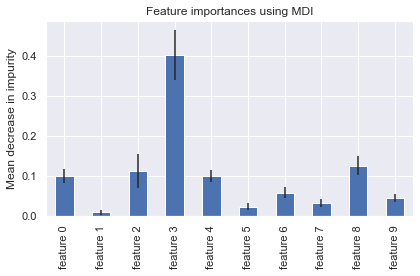

In [65]:
feature_names = [f'feature {i}' for i in range(X_train_std_RF.shape[1])]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [66]:
features_serie = pd.Series(X_train.columns)
features_serie

0                                    YearBuilt
1                            NumberofBuildings
2                               NumberofFloors
3                             PropertyGFATotal
4                              ENERGYSTARScore
5                 energy_type_03_TargetEncoded
6                 energy_type_02_TargetEncoded
7                 energy_type_01_TargetEncoded
8    PrimaryPropertyType_new_cat_TargetEncoded
9            CouncilDistrictCode_TargetEncoded
dtype: object

### Sélections des features avec seuil

In [67]:
select = SelectFromModel(model, prefit=True, threshold=0.01)
X_train_std_2 = select.transform(X_train_std_RF)
X_test_std_2 = select.transform(X_test_std)
print(X_train_std_2.shape)

(1788, 9)


### Selections paramètres avec grid search

### Ré-entrainement après sélection des 'most important features'

In [68]:
rfc2 = RandomForestClassifier(n_estimators=500, oob_score=True)

start_time = timeit.default_timer()

rfc2 = rfc2.fit(X_train_std_2, y_train)

pred = rfc2.predict(X_test_std_2)
elapsed = timeit.default_timer() - start_time
accuracy = accuracy_score(y_test, pred)

print("accuracy: {:.2f}; time: {:.2f}s".format(accuracy, elapsed))

accuracy: 0.83; time: 1.17s


In [69]:
# Get columns to keep and create new dataframe with those only
cols = select.get_support(indices=True)
features_df_new = X_train_std_RF.iloc[:,cols]
features_df_new

,YearBuilt,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,PrimaryPropertyType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded
0,-1.339714,-0.704451,-0.362501,0.383065,-0.156124,0.455220,0.951494,-0.650386,0.716375
1,-1.370587,-0.344680,-0.489054,-0.391781,-0.131984,-1.169056,-0.312911,-0.584665,1.190951
2,-1.524950,0.554748,-0.233825,-1.511003,-0.182475,-1.205106,-0.391828,1.252174,1.190951
3,-1.432332,0.194977,-0.382831,0.383065,-0.156124,0.640507,-0.392363,-0.650386,-0.707351
4,-1.339714,-0.344680,-0.502772,0.856582,-0.182475,0.643783,-0.391828,-0.619902,-0.232776
...,...,...,...,...,...,...,...,...,...
1783,0.667008,0.015091,-0.221158,0.512206,-0.156124,-1.210099,-0.392363,-0.650386,1.190951
1784,1.068353,-0.164795,-0.498547,0.942676,-0.156124,0.640507,-0.392363,-0.650386,1.190951
1785,0.327409,-0.344680,-0.461680,0.684394,-0.182475,-1.205106,-0.391828,-0.619902,-1.656502
1786,0.358282,0.015091,1.263083,0.296971,-0.131984,-1.169056,-0.312911,1.274364,1.190951


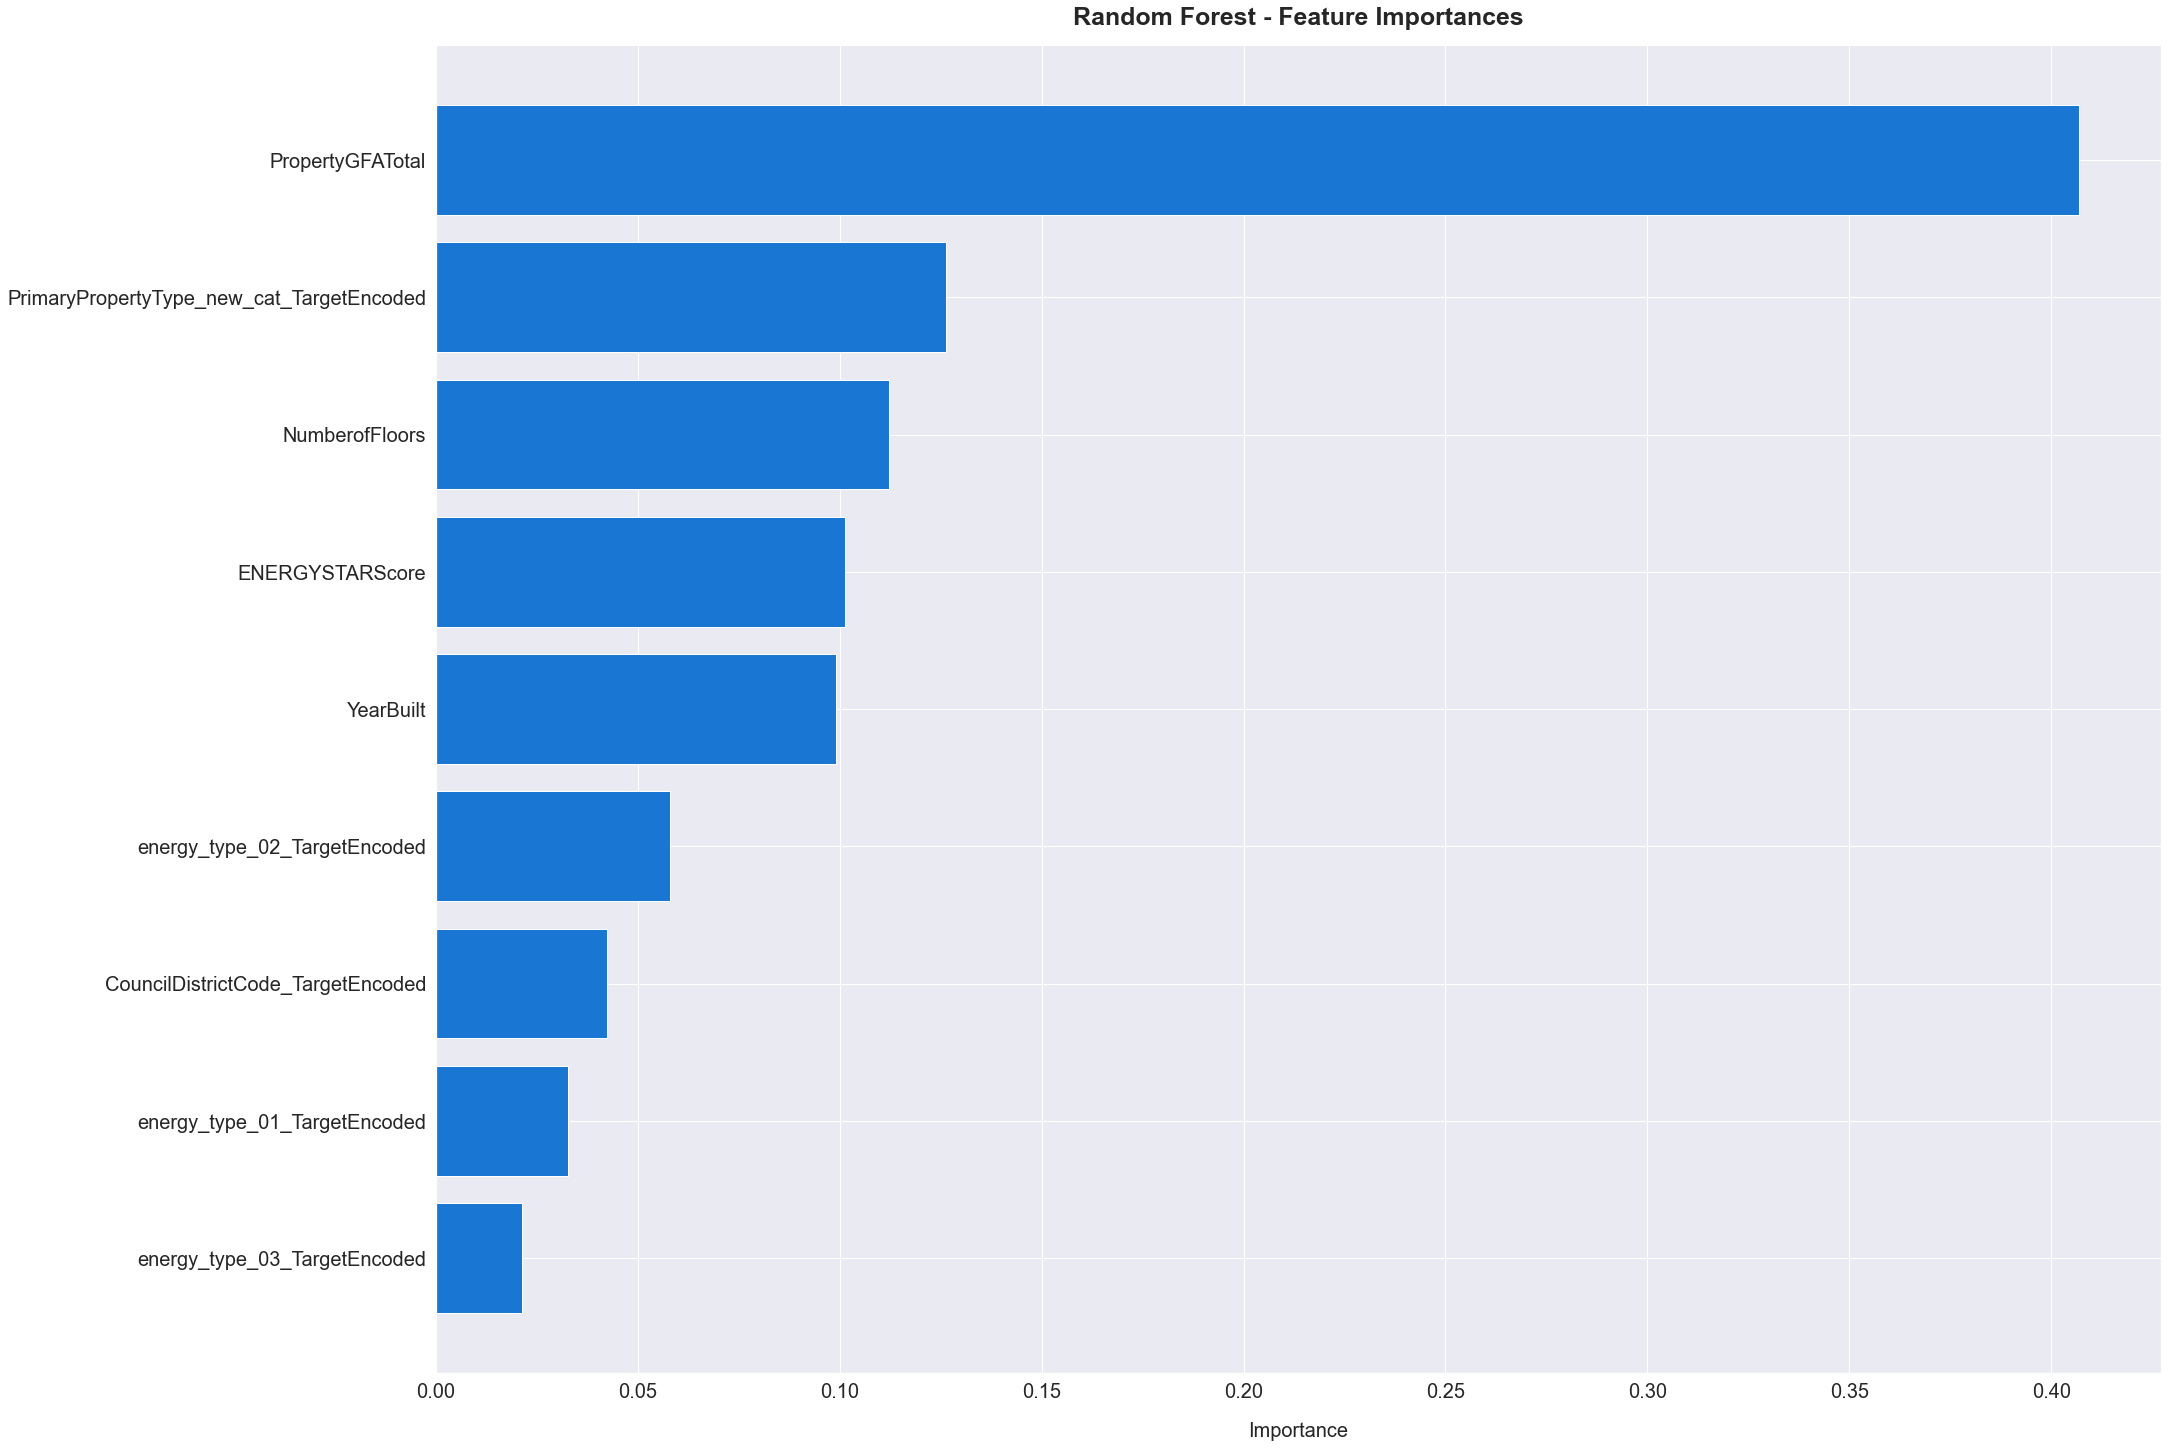

In [295]:
dset = pd.DataFrame()
dset['attr'] = features_df_new.columns
dset['importance'] = rfc2.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)

plt.figure(figsize=(30, 20), constrained_layout=True)
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest - Feature Importances', fontsize=25, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=20, labelpad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# enregistrement d'image
plt.savefig('projets\\04_seattle_building_energy\\production\\savefig\\feature_selection\\feature_selectionRandom_forest_feature_importance.png', transparent=True, dpi=300)

plt.show()

In [71]:
print("accuracy: {:.2f}; time: {:.2f}s".format(accuracy, elapsed))

accuracy: 0.83; time: 1.17s


Seulement une optimisatipon manuelle a été faite sans amélioration

## Feature selection (RFECV - Random Forest)

In [72]:
X_train_std_RFECV = X_train_std.copy()

In [73]:
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, scoring='accuracy')

start_time = timeit.default_timer()

rfecv.fit(X_train_std_RFECV , y_train)

pred = rfecv.predict(X_test_std)
elapsed = timeit.default_timer() - start_time
accuracy = accuracy_score(y_test, pred)

print("accuracy: {:.2f}; time: {:.2f}s".format(accuracy, elapsed))

accuracy: 0.83; time: 9.02s


In [74]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 9


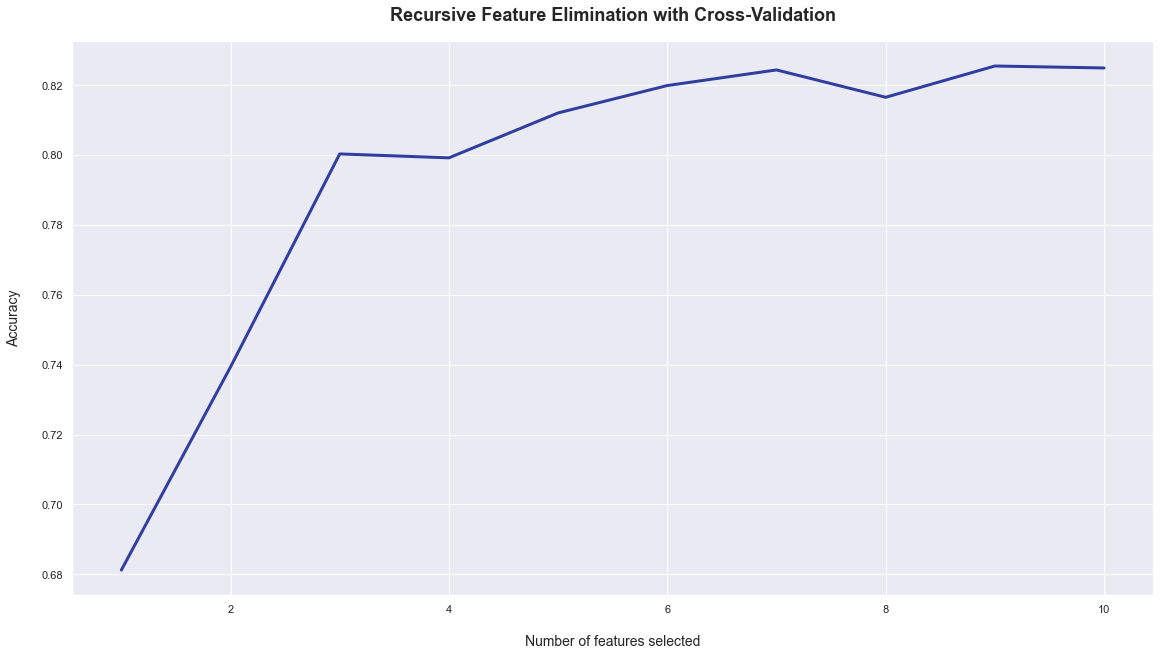

In [297]:
plt.figure(figsize=(16, 9), constrained_layout=True)
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('Accuracy', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

# enregistrement d'image
plt.savefig('projets\\04_seattle_building_energy\\production\\savefig\\feature_selection\\feature_selection_RFECV_accuracy.png', transparent=True)

plt.show()

In [76]:
# Least important features

print(np.where(rfecv.support_ == False)[0])

X_train_std_RFECV .drop(X_train_std_RFECV .columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_train_std_RFECV 

[1]


,YearBuilt,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,PrimaryPropertyType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded
0,-1.339714,-0.704451,-0.362501,0.383065,-0.156124,0.455220,0.951494,-0.650386,0.716375
1,-1.370587,-0.344680,-0.489054,-0.391781,-0.131984,-1.169056,-0.312911,-0.584665,1.190951
2,-1.524950,0.554748,-0.233825,-1.511003,-0.182475,-1.205106,-0.391828,1.252174,1.190951
3,-1.432332,0.194977,-0.382831,0.383065,-0.156124,0.640507,-0.392363,-0.650386,-0.707351
4,-1.339714,-0.344680,-0.502772,0.856582,-0.182475,0.643783,-0.391828,-0.619902,-0.232776
...,...,...,...,...,...,...,...,...,...
1783,0.667008,0.015091,-0.221158,0.512206,-0.156124,-1.210099,-0.392363,-0.650386,1.190951
1784,1.068353,-0.164795,-0.498547,0.942676,-0.156124,0.640507,-0.392363,-0.650386,1.190951
1785,0.327409,-0.344680,-0.461680,0.684394,-0.182475,-1.205106,-0.391828,-0.619902,-1.656502
1786,0.358282,0.015091,1.263083,0.296971,-0.131984,-1.169056,-0.312911,1.274364,1.190951


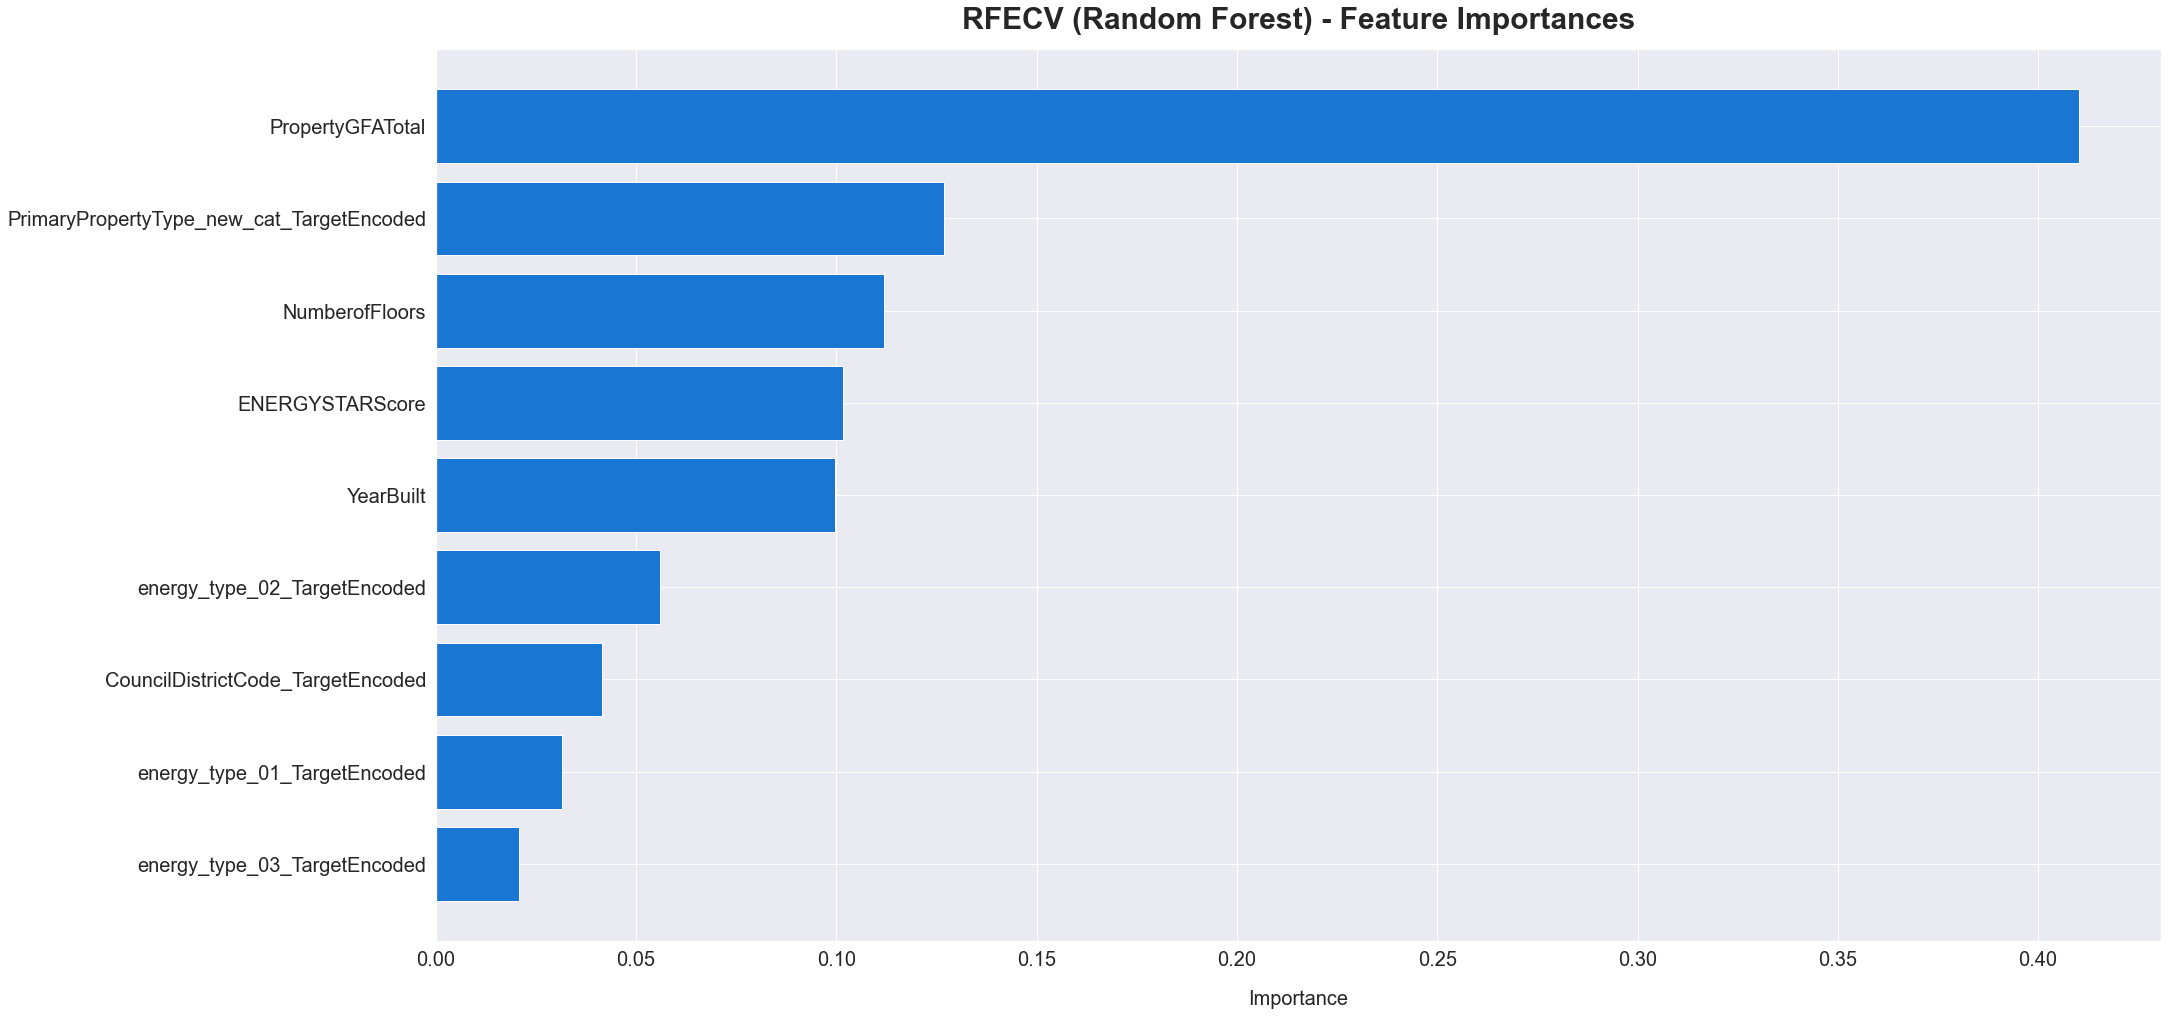

In [294]:
dset = pd.DataFrame()
dset['attr'] = X_train_std_RFECV .columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)

plt.figure(figsize=(30, 14), constrained_layout=True)
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV (Random Forest) - Feature Importances', fontsize=30, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=20, labelpad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# enregistrement d'image
plt.savefig('projets\\04_seattle_building_energy\\production\\savefig\\feature_selection\\feature_selection_RFECV.png', transparent=True)

plt.show()

In [78]:
print("accuracy: {:.2f}; time: {:.2f}s".format(accuracy, elapsed))

accuracy: 0.83; time: 9.02s


### Features selected

In [79]:
# Choix 1
if ENERGYSTARScore_choice == 'oui':
    features_selected_lst = ['PropertyGFATotal','YearBuilt','ENERGYSTARScore','NumberofFloors',
                             'energy_type_02_LabelEncoded']
    features_selected_lst

In [80]:
# Choix 2
if ENERGYSTARScore_choice == 'non':
    features_selected_lst = ['PropertyGFATotal','YearBuilt','NumberofFloors']
    features_selected_lst

# PREDICTIONS (TRAIN/VAL)

## Split train/validation du dataset avec target numérique

Les colonnes sont filtrées avec les features sélectionnées

Les variables 'energy_type_02' et 'CouncilDistrictCode' sont utilisées avec one-hot encoding et les features non importantes sont suprimées

Targets numériques utilisées

In [81]:
# Choix 1
if ENERGYSTARScore_choice == 'oui':

    modified_features_selected_lst  = features_selected_lst

    # Suppression de target encoding
    modified_features_selected_lst.remove('energy_type_02_LabelEncoded')

    #Ajout de one_hot encoding
    
    energy_type_lst = ['energy_type_02_<electricity>', 'energy_type_02_<gas>',
                     'energy_type_02_<steam>', 'energy_type_02_<Class Missing>']
    
    PrimaryPropertyType_lst = ['PrimaryPropertyType_new_cat_<Commercial centers>',
                               'PrimaryPropertyType_new_cat_<Education>',
                               'PrimaryPropertyType_new_cat_<Health services>',
                               'PrimaryPropertyType_new_cat_<Hotel/Restaurant>',
                               'PrimaryPropertyType_new_cat_<Industry>',
                               'PrimaryPropertyType_new_cat_<Logistic/Distribution centers>',
                               'PrimaryPropertyType_new_cat_<Mixed Use Property>',
                               'PrimaryPropertyType_new_cat_<Multifamily Housing>',
                               'PrimaryPropertyType_new_cat_<Office>',
                               'PrimaryPropertyType_new_cat_<Other/Public places>',
                               'PrimaryPropertyType_new_cat_<Class Missing>']
                            
                               
    modified_features_selected_lst = features_selected_lst + energy_type_lst + PrimaryPropertyType_lst
    modified_features_selected_lst

In [82]:
# Choix 2
if ENERGYSTARScore_choice == 'non':
    
    #Ajout de one_hot encoding
    
    energy_type_lst = ['energy_type_02_<electricity>', 'energy_type_02_<gas>',
                     'energy_type_02_<steam>', 'energy_type_02_<Class Missing>']
    
    PrimaryPropertyType_lst = ['PrimaryPropertyType_new_cat_<Commercial centers>',
                               'PrimaryPropertyType_new_cat_<Education>',
                               'PrimaryPropertyType_new_cat_<Health services>',
                               'PrimaryPropertyType_new_cat_<Hotel/Restaurant>',
                               'PrimaryPropertyType_new_cat_<Industry>',
                               'PrimaryPropertyType_new_cat_<Logistic/Distribution centers>',
                               'PrimaryPropertyType_new_cat_<Mixed Use Property>',
                               'PrimaryPropertyType_new_cat_<Multifamily Housing>',
                               'PrimaryPropertyType_new_cat_<Office>',
                               'PrimaryPropertyType_new_cat_<Other/Public places>',
                               'PrimaryPropertyType_new_cat_<Class Missing>']
    
    
    modified_features_selected_lst  = features_selected_lst + PrimaryPropertyType_lst + energy_type_lst


In [83]:
modified_features_selected_lst

['PropertyGFATotal',
 'YearBuilt',
 'ENERGYSTARScore',
 'NumberofFloors',
 'energy_type_02_<electricity>',
 'energy_type_02_<gas>',
 'energy_type_02_<steam>',
 'energy_type_02_<Class Missing>',
 'PrimaryPropertyType_new_cat_<Commercial centers>',
 'PrimaryPropertyType_new_cat_<Education>',
 'PrimaryPropertyType_new_cat_<Health services>',
 'PrimaryPropertyType_new_cat_<Hotel/Restaurant>',
 'PrimaryPropertyType_new_cat_<Industry>',
 'PrimaryPropertyType_new_cat_<Logistic/Distribution centers>',
 'PrimaryPropertyType_new_cat_<Mixed Use Property>',
 'PrimaryPropertyType_new_cat_<Multifamily Housing>',
 'PrimaryPropertyType_new_cat_<Office>',
 'PrimaryPropertyType_new_cat_<Other/Public places>',
 'PrimaryPropertyType_new_cat_<Class Missing>']

In [84]:
# Suppression des targets
data_fix_set_train_val_random_bis_X = data_fix_set_train_val_random_freezed.copy()
data_fix_set_train_val_random_bis_X = data_fix_set_train_val_random_bis_X[modified_features_selected_lst]

In [85]:
X_bis = data_fix_set_train_val_random_bis_X
y_bis = data_fix_set_train_val_random['SiteEnergyUseWN(kBtu)']

In [86]:
X_bis

,PropertyGFATotal,YearBuilt,ENERGYSTARScore,NumberofFloors,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>,energy_type_02_<Class Missing>,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,PrimaryPropertyType_new_cat_<Class Missing>
5298,88434,1927.0,65.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,103566,1996.0,72.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2557,956110,1969.0,43.0,41.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5215,119890,1980.0,67.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2559,83008,1926.0,27.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7542,44650,2000.0,71.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2551,42393,2014.0,94.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2552,319481,2015.0,79.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7660,48230,1981.0,44.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [87]:
X_bis_train, X_bis_test, y_bis_train, y_bis_test = \
	train_test_split(X_bis, y_bis,
                     test_size=0.3 # 30% des données dans le jeu de test
                    ,random_state=1)

In [88]:
# standardiser les données
std_scale = preprocessing.StandardScaler().fit(X_bis_train)

X_bis_train_std = std_scale.transform(X_bis_train)
X_bis_test_std = std_scale.transform(X_bis_test)

In [89]:
# Passage en Dataframe pour garder le nom des features
X_bis_train_std = pd.DataFrame(X_bis_train_std, columns=X_bis_train.columns)
X_bis_test_std  = pd.DataFrame(X_bis_test_std , columns=X_bis_train.columns)

In [90]:
# Création d'un dictionnaire pour récolter tous les résultats de modèles:
train_model_model_results = {}

## Baseline : une régression Dummy

In [91]:
# modèle aléatoire qui retourne systématiquement la valeur moyenne du jeu de données d'entraînement.
dum = dummy.DummyRegressor(strategy='mean')

start_time = timeit.default_timer()
# Entraînement
dum.fit(X_bis_train_std, y_bis_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_bis_test_std)


baseline_error = np.sqrt(metrics.mean_squared_error(y_bis_test, y_pred_dum)) 
elapsed = timeit.default_timer() - start_time

# Evaluate
print("RMSE - baseline : {:.2f}; time: {:.2f}s".format(baseline_error, elapsed))
train_model_model_results['dummy_regression'] = [baseline_error,0]

RMSE - baseline : 0.49; time: 0.00s


## Régression classique

In [92]:
# On crée un modèle de régression linéaire
lr = linear_model.LinearRegression()

start_time = timeit.default_timer()
# On entraîne ce modèle sur les données d'entrainement
lr.fit(X_bis_train_std, y_bis_train)


# On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
#baseline_error = np.mean((lr.predict(X_bis_test_std) - y_bis_test) ** 2)
error = np.sqrt(metrics.mean_squared_error(lr.predict(X_bis_test_std), y_bis_test))
elapsed = timeit.default_timer() - start_time

# RMSE:
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['classic_regression'] = [error,elapsed]

RMSE: 0.30; temps: 0.01s/ RMSE - baseline: 0.49


## Régression Ridge

In [93]:
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

In [94]:
ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    
    start_time = timeit.default_timer()
    ridge.fit(X_bis_train_std, y_bis_train)
    
    coefs.append(ridge.coef_)
    error = np.sqrt(metrics.mean_squared_error(ridge.predict(X_bis_test_std), y_bis_test))
    
    elapsed = timeit.default_timer() - start_time
    errors.append([baseline_error, error])

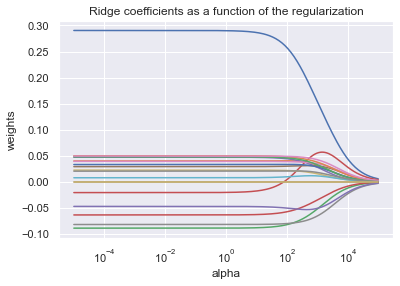

In [95]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [96]:
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['ridge_regression'] = [error,elapsed]

RMSE: 0.48; temps: 0.00s/ RMSE - baseline: 0.49


## Régression Lasso

In [97]:
n_alphas = 300
alphas = np.logspace(-5, 1, n_alphas)
lasso = linear_model.Lasso(fit_intercept=False)
errors = []

coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    
    start_time = timeit.default_timer()
    lasso.fit(X_bis_train_std, y_bis_train)
    
    coefs.append(lasso.coef_)
    error = np.sqrt(metrics.mean_squared_error(lasso.predict(X_bis_test_std), y_bis_test))
    elapsed = timeit.default_timer() - start_time
    
    errors.append([baseline_error, error])

C:\Users\vince\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 433.42666781824664, tolerance: 7.298177328371481
  model = cd_fast.enet_coordinate_descent(
C:\Users\vince\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 433.4268148726551, tolerance: 7.298177328371481
  model = cd_fast.enet_coordinate_descent(
C:\Users\vince\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 433.4269680556099, tolerance: 7.298177328371481
  model = cd_fast.enet_coordinate_descent(
C:\Users\vince\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

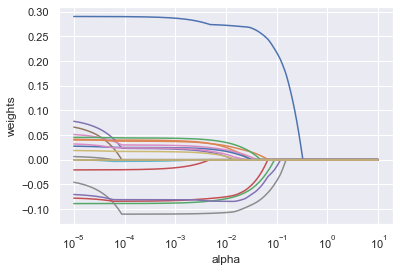

In [98]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

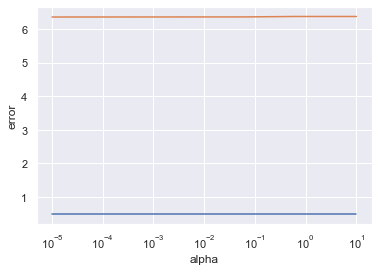

In [99]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [100]:
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['lasso_regression'] = [error,elapsed]

RMSE: 6.38; temps: 0.00s/ RMSE - baseline: 0.49


## Decision Tree Regressor

In [101]:
# Fit the regressor, set max_depth = 3
dt_regr = DecisionTreeRegressor(max_depth=3, random_state=1234)

start_time = timeit.default_timer()
model = dt_regr.fit(X_bis_train_std, y_bis_train)

error = np.sqrt(metrics.mean_squared_error(dt_regr.predict(X_bis_test_std), y_bis_test))
elapsed = timeit.default_timer() - start_time

print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['decision_tree_regressor'] = [error,elapsed]

RMSE: 0.28; temps: 0.00s/ RMSE - baseline: 0.49


In [102]:
text_representation = tree.export_text(dt_regr)
print(text_representation)

|--- feature_0 <= -0.06
|   |--- feature_0 <= -0.35
|   |   |--- feature_7 <= 0.28
|   |   |   |--- value: [6.16]
|   |   |--- feature_7 >  0.28
|   |   |   |--- value: [5.91]
|   |--- feature_0 >  -0.35
|   |   |--- feature_7 <= 0.28
|   |   |   |--- value: [6.47]
|   |   |--- feature_7 >  0.28
|   |   |   |--- value: [6.22]
|--- feature_0 >  -0.06
|   |--- feature_0 <= 0.95
|   |   |--- feature_0 <= 0.42
|   |   |   |--- value: [6.64]
|   |   |--- feature_0 >  0.42
|   |   |   |--- value: [6.89]
|   |--- feature_0 >  0.95
|   |   |--- feature_0 <= 2.86
|   |   |   |--- value: [7.19]
|   |   |--- feature_0 >  2.86
|   |   |   |--- value: [7.60]



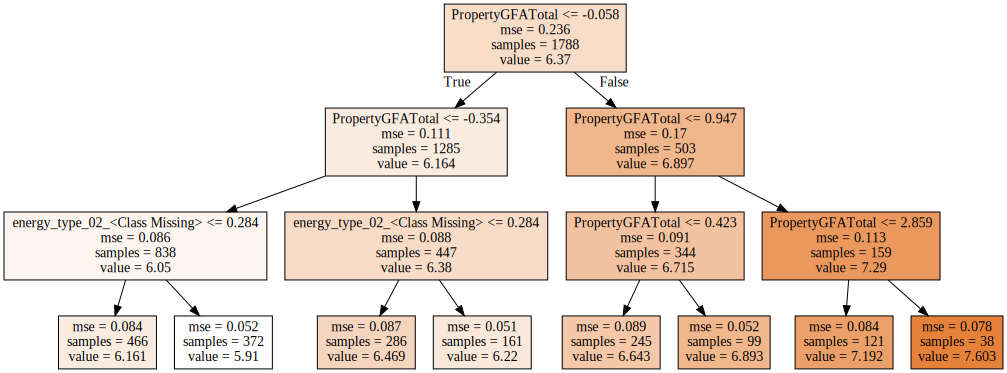

In [103]:

dot_data = tree.export_graphviz(dt_regr, out_file=None, 
                                feature_names=modified_features_selected_lst,  
                                filled=True)
src = graphviz.Source(dot_data, format="png") 

# save fig
src.render('projets\\04_seattle_building_energy\\production\\savefig\\model_results\\decision_tree.gv', view=True)

# afficher
src

In [104]:
viz = dtreeviz(dt_regr,
               X_bis_train_std,
               y_bis_train,
               target_name='SiteEnergyUseWN(kBtu)',
               feature_names=modified_features_selected_lst)
              
viz.view()

### GridSearchCV

In [105]:

#dt = DecisionTreeRegressor(random_state=1234)
dt_gcv = GridSearchCV(estimator=dt_regr,
              param_grid={'min_samples_split': range(2, 10)},
    cv=5, refit=True)

start_time = timeit.default_timer()
dt_gcv.fit(X_bis_train_std, y_bis_train)
dt_gcv.best_params_

{'min_samples_split': 2}

In [106]:
error = np.sqrt(metrics.mean_squared_error(dt_gcv.predict(X_bis_test_std), y_bis_test))
elapsed = timeit.default_timer() - start_time

print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['dtr_GridSearchCV'] = [error,elapsed]

RMSE: 0.28; temps: 0.27s/ RMSE - baseline: 0.49


## Random forest Regressor

In [107]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Fit the search model
start_time = timeit.default_timer()
rf.fit(X_bis_train_std, y_bis_train)

RandomForestRegressor()

In [108]:
error = np.sqrt(metrics.mean_squared_error(rf.predict(X_bis_test_std), y_bis_test))
elapsed = timeit.default_timer() - start_time

print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['random_forest_regressor'] = [error,elapsed]

RMSE: 0.21; temps: 0.45s/ RMSE - baseline: 0.49


### Random Hyperparameter Grid

- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [109]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [20, 50, 100, 200]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 30, 40, 50]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100, None], 'min_samples_split': [20, 50, 100, 200], 'min_samples_leaf': [10, 30, 40, 50], 'bootstrap': [True, False]}


In [110]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
start_time = timeit.default_timer()
rf_random.fit(X_bis_train_std, y_bis_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 19, 28, 37, 46, 55,
                                                      64, 73, 82, 91, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [10, 30, 40, 50],
                                        'min_samples_split': [20, 50, 100, 200],
                                        'n_estimators': [30, 60, 90, 120, 150,
                                                         180, 210, 240, 270,
                                                         300]},
                   random_state=42, verbose=2)

In [111]:
rf_random.best_params_

{'n_estimators': 270,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_features': 'auto',
 'max_depth': 64,
 'bootstrap': True}

In [112]:
error = np.sqrt(metrics.mean_squared_error(rf_random.predict(X_bis_test_std), y_bis_test))
elapsed = timeit.default_timer() - start_time

print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['rfr_RandomHyperparameterGrid_'] = [error,elapsed]

RMSE: 0.22; temps: 9.46s/ RMSE - baseline: 0.49


### GridSearchCV

In [113]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
#rf = RandomForestRegressor()
# Instantiate the grid search model
rf_gcv = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
start_time = timeit.default_timer()
rf_gcv.fit(X_bis_train_std, y_bis_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [114]:
rf_gcv.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [115]:
error = np.sqrt(metrics.mean_squared_error(rf_gcv.predict(X_bis_test_std), y_bis_test))
elapsed = timeit.default_timer() - start_time

print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['rfr_GridSearchCV'] = [error,elapsed]

RMSE: 0.23; temps: 41.88s/ RMSE - baseline: 0.49


## XGBoost

In [116]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)
# Fit model
start_time = timeit.default_timer()
xg_reg.fit(X_bis_train_std.values, y_bis_train)


error = np.sqrt(metrics.mean_squared_error(xg_reg.predict(X_bis_test), y_bis_test))
elapsed = timeit.default_timer() - start_time
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['XGBoost_regressor'] = [error,elapsed]

RMSE: 0.86; temps: 0.01s/ RMSE - baseline: 0.49


### GridSearchCV 

In [117]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)], 'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
# Initialize XGB and GridSearch
#xgb = xgb.XGBRegressor(nthread=-1)
grid_xgb = GridSearchCV(xg_reg, params)

# Fit model
start_time = timeit.default_timer()
grid_xgb.fit(X_bis_train_std.values, y_bis_train)


# error
error = np.sqrt(metrics.mean_squared_error(grid_xgb.predict(X_bis_test), y_bis_test))
elapsed = timeit.default_timer() - start_time
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['XGBoost_r_GridSearchCV'] = [error,elapsed]

RMSE: 0.89; temps: 24.36s/ RMSE - baseline: 0.49


## CatBoostRegressor

In [118]:
#Initialize data
#cat_features = [0,1,2]

# Initialize CatBoostRegressor
catb_reg = CatBoostRegressor(iterations=3, learning_rate=1, depth=5)

# Fit model
start_time = timeit.default_timer()
catb_reg.fit(X_bis_train_std, y_bis_train)


error = np.sqrt(metrics.mean_squared_error(catb_reg.predict(X_bis_test_std), y_bis_test))
elapsed = timeit.default_timer() - start_time
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['CATBoost_regressor'] = [error,elapsed]

0:	learn: 0.2891252	total: 138ms	remaining: 275ms
1:	learn: 0.2491444	total: 139ms	remaining: 69.3ms
2:	learn: 0.2335794	total: 139ms	remaining: 0us
RMSE: 0.25; temps: 0.18s/ RMSE - baseline: 0.49


### GridSearchCV

In [119]:
model = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }

grid_cat = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
start_time = timeit.default_timer()
grid_cat.fit(X_bis_train_std, y_bis_train)


0:	learn: 0.4540213	total: 1.89ms	remaining: 187ms
1:	learn: 0.4277288	total: 2.97ms	remaining: 145ms
2:	learn: 0.4035269	total: 3.93ms	remaining: 127ms
3:	learn: 0.3813411	total: 4.87ms	remaining: 117ms
4:	learn: 0.3641930	total: 5.82ms	remaining: 111ms
5:	learn: 0.3466859	total: 6.8ms	remaining: 107ms
6:	learn: 0.3296395	total: 7.79ms	remaining: 103ms
7:	learn: 0.3175863	total: 8.71ms	remaining: 100ms
8:	learn: 0.3051915	total: 9.65ms	remaining: 97.6ms
9:	learn: 0.2947915	total: 10.6ms	remaining: 95.2ms
10:	learn: 0.2849406	total: 11.5ms	remaining: 93.3ms
11:	learn: 0.2761302	total: 12.4ms	remaining: 91.3ms
12:	learn: 0.2684493	total: 13.4ms	remaining: 89.8ms
13:	learn: 0.2599665	total: 14.5ms	remaining: 88.8ms
14:	learn: 0.2551310	total: 15.4ms	remaining: 87.5ms
15:	learn: 0.2487109	total: 16.5ms	remaining: 86.6ms
16:	learn: 0.2440324	total: 17.5ms	remaining: 85.7ms
17:	learn: 0.2396890	total: 18.6ms	remaining: 84.6ms
18:	learn: 0.2352874	total: 19.7ms	remaining: 83.8ms
19:	learn: 0

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000261B33EB160>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [120]:
error = np.sqrt(metrics.mean_squared_error(grid_cat.predict(X_bis_test_std), y_bis_test))
elapsed = timeit.default_timer() - start_time

print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['CATBoost_r_GridSearchCV'] = [error,elapsed]

RMSE: 0.19; temps: 4.97s/ RMSE - baseline: 0.49


## SVM 

In [121]:


svr_regr = svm.SVR(C=1.0, epsilon=0.2)

start_time = timeit.default_timer()
svr_regr.fit(X_bis_train_std, y_bis_train)


error = np.sqrt(metrics.mean_squared_error(svr_regr.predict(X_bis_test_std), y_bis_test))
elapsed = timeit.default_timer() - start_time

print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['SVM_regressor'] = [error,elapsed]

RMSE: 0.24; temps: 0.07s/ RMSE - baseline: 0.49


### GridSearchCV

## Results

In [122]:
# Results
train_model_model_results

{'dummy_regression': [0.48862991111986526, 0],
 'classic_regression': [0.3047792308230496, 0.010014800000000434],
 'ridge_regression': [0.47760763903824494, 0.0026318000000031816],
 'lasso_regression': [6.381864485322128, 0.0019257000000010294],
 'decision_tree_regressor': [0.27772987014051076, 0.004558599999995749],
 'dtr_GridSearchCV': [0.27772987014051076, 0.2696791999999988],
 'random_forest_regressor': [0.21104138589362567, 0.4520002000000005],
 'rfr_RandomHyperparameterGrid_': [0.2178166463963176, 9.456198000000008],
 'rfr_GridSearchCV': [0.2279520268248104, 41.8835718],
 'XGBoost_regressor': [0.8612161012502607, 0.01341870000000256],
 'XGBoost_r_GridSearchCV': [0.8886539022646089, 24.362323400000008],
 'CATBoost_regressor': [0.24787151123114878, 0.18049620000002164],
 'CATBoost_r_GridSearchCV': [0.19153269357883537, 4.968911999999989],
 'SVM_regressor': [0.23664826199773706, 0.07089809999999375]}

In [123]:
# dataframe results:
train_model_model_results_df = pd.DataFrame(list(train_model_model_results.items()),
                   columns=['Model', '[RMSE, Computing_time]'])

In [124]:
train_model_model_results_df['RMSE'] = train_model_model_results_df['[RMSE, Computing_time]'].apply(lambda x: round(x[0],2))
train_model_model_results_df['Computing_time'] = train_model_model_results_df['[RMSE, Computing_time]'].apply(lambda x: round(x[1],2))
train_model_model_results_df.drop('[RMSE, Computing_time]',axis=1, inplace=True)


In [125]:
train_model_model_results_df.sort_values(by=['RMSE'], inplace = True)
train_model_model_results_df

,Model,RMSE,Computing_time
12,CATBoost_r_GridSearchCV,0.19,4.97
6,random_forest_regressor,0.21,0.45
7,rfr_RandomHyperparameterGrid_,0.22,9.46
8,rfr_GridSearchCV,0.23,41.88
13,SVM_regressor,0.24,0.07
11,CATBoost_regressor,0.25,0.18
4,decision_tree_regressor,0.28,0.00
5,dtr_GridSearchCV,0.28,0.27
1,classic_regression,0.30,0.01
2,ridge_regression,0.48,0.00


In [126]:
# Zoomons dans le coin de la figure

train_model_model_results_df_filtered = train_model_model_results_df[train_model_model_results_df['RMSE']<1]
train_model_model_results_df_filtered = train_model_model_results_df_filtered[train_model_model_results_df['Computing_time']<10] 

<ipython-input-126-1392a89c2fc6>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_model_model_results_df_filtered = train_model_model_results_df_filtered[train_model_model_results_df['Computing_time']<10]


In [127]:
train_model_model_results_df_filtered.sort_values(by=['RMSE'], inplace = True)
train_model_model_results_df_filtered

,Model,RMSE,Computing_time
12,CATBoost_r_GridSearchCV,0.19,4.97
6,random_forest_regressor,0.21,0.45
7,rfr_RandomHyperparameterGrid_,0.22,9.46
13,SVM_regressor,0.24,0.07
11,CATBoost_regressor,0.25,0.18
4,decision_tree_regressor,0.28,0.00
5,dtr_GridSearchCV,0.28,0.27
1,classic_regression,0.30,0.01
2,ridge_regression,0.48,0.00
0,dummy_regression,0.49,0.00


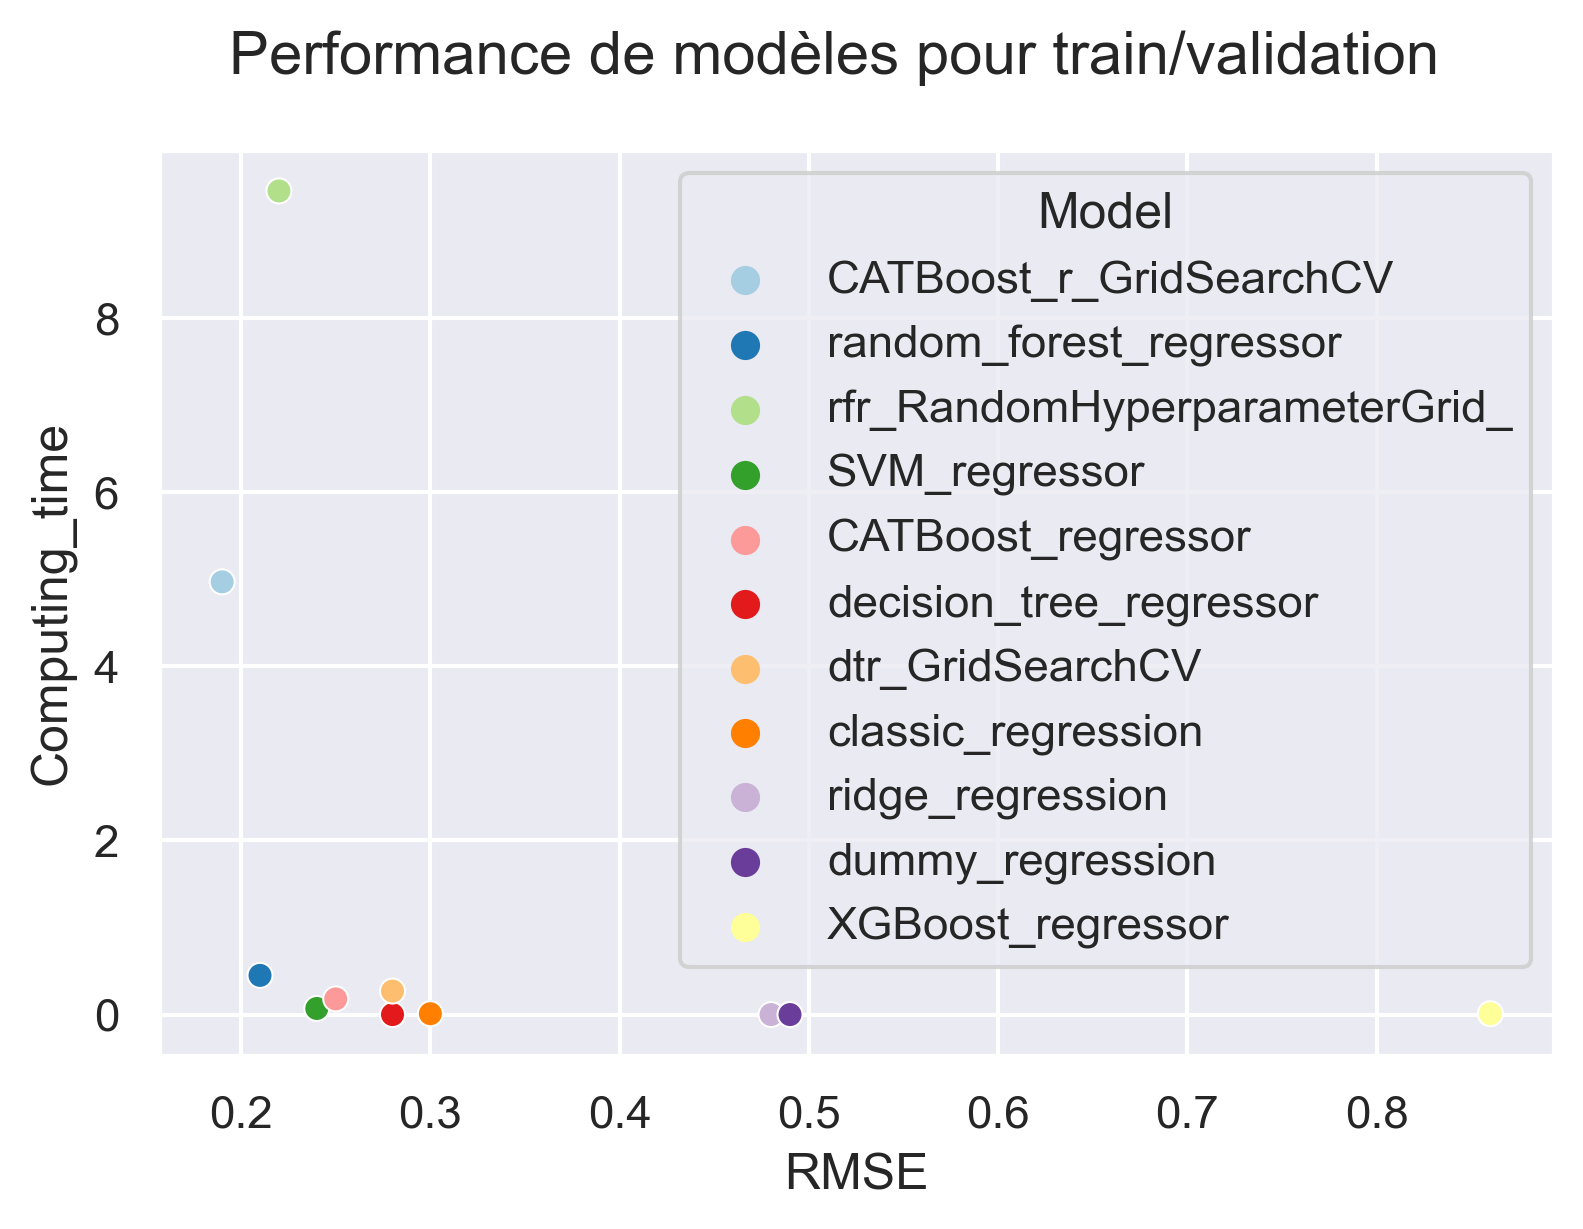

In [128]:
# plot des résultats
my_pal = sns.color_palette("Paired", n_colors = train_model_model_results_df_filtered.shape[0])

fig, ax = plt.subplots(1, 1, dpi=300)
sns.scatterplot(data=train_model_model_results_df_filtered, x="RMSE", y="Computing_time", hue=train_model_model_results_df_filtered.Model, 
                palette=my_pal, 
                legend='full')
#Titres de figures
fig.suptitle('Performance de modèles pour train/validation')

# Enregistrement de figure
fig.savefig("projets\\04_seattle_building_energy\\production\\savefig\\model_results\\Performance de modèles pour train-validation.png", transparent=True, dpi=300)

# Calcul des coefficients WN entre 'SiteEnergyUse(kBtu)' et 'SiteEnergyUseWN(kBtu)'




2017
Nombre de points: 2555 dont train: 1800
Coefficients: 
 [[1.00677209]]
Erreur quadratique moyenne: 51444789218.03
Coefficient of determination: 1.00
Coefficient WN: 1.007


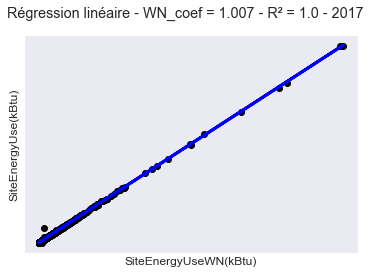




2016
Nombre de points: 2555 dont train: 1800
Coefficients: 
 [[0.98750656]]
Erreur quadratique moyenne: 49339380419.57
Coefficient of determination: 1.00
Coefficient WN: 0.988


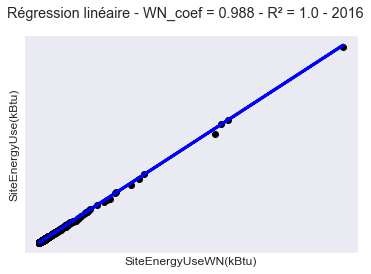




2015
Nombre de points: 2555 dont train: 1800
Coefficients: 
 [[0.98181686]]
Erreur quadratique moyenne: 149779973729.93
Coefficient of determination: 1.00
Coefficient WN: 0.982


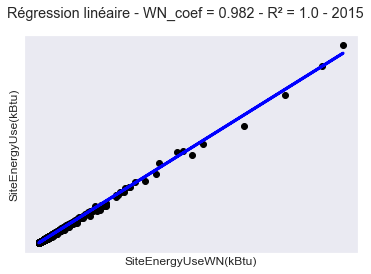




2018
Nombre de points: 2555 dont train: 1800
Coefficients: 
 [[0.99108944]]
Erreur quadratique moyenne: 97906782671.16
Coefficient of determination: 1.00
Coefficient WN: 0.991


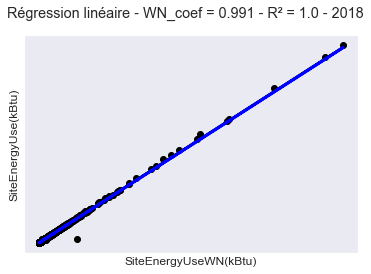




2019
Nombre de points: 2463 dont train: 1800
Coefficients: 
 [[0.9890786]]
Erreur quadratique moyenne: 374531006551.42
Coefficient of determination: 0.99
Coefficient WN: 0.989


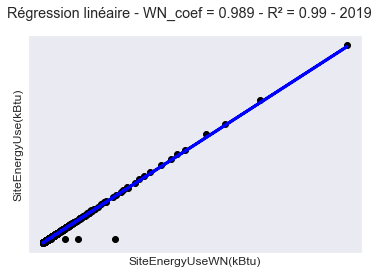

In [239]:
# années year_minus_1,year_minus_2,year_minus_3,year,year_plus_1:

WN_coef = {}

for data_year in [year_minus_1,year_minus_2,year_minus_3,year,year_plus_1]:
    
    # Création du dataframe filtré sur l'année
    df = data_fix_set[data_year].copy()
    df_year = df[df['DataYear'] == int(data_year)]
    
    # Passage de log() à exp() pour revenir aux valeurs d'origine
    df_year['SiteEnergyUseWN(kBtu)_bis'] = df_year['SiteEnergyUseWN(kBtu)'].apply(lambda x: np.power(10,x))
    df_year['SiteEnergyUse(kBtu)_bis'] = df_year['SiteEnergyUse(kBtu)'].apply(lambda x: np.power(10,x))
    
    # Split de l'entrée en training/testing sets
    energy_X_train = df_year['SiteEnergyUseWN(kBtu)_bis'][:-1800].values.reshape(-1, 1)
    energy_X_test = df_year['SiteEnergyUseWN(kBtu)_bis'][-1800:].values.reshape(-1, 1)

    # Split de la target en training/testing sets
    energy_y_train = df_year['SiteEnergyUse(kBtu)_bis'][:-1800].values.reshape(-1, 1)
    energy_y_test = df_year['SiteEnergyUse(kBtu)_bis'][-1800:].values.reshape(-1, 1)

    # Création d'objet de régression linéaire
    regr = linear_model.LinearRegression()

    # Entraînement du modèle utilisant le training set
    regr.fit(energy_X_train, energy_y_train)

    # Prédictions à partir du set test
    energy_y_pred = regr.predict(energy_X_test)
        
    # Année
    print("\n\n")
    print(int(data_year))
    
    # Nombre de points:
    print(f"Nombre de points: {df_year.shape[0]} dont train: 1800")
    
    # Les coeffcients
    print('Coefficients: \n', regr.coef_)
    
    # Erreur quadratique moyenne
    MSE = mean_squared_error(energy_y_test, energy_y_pred)
    print('Erreur quadratique moyenne: %.2f'
          % MSE)
    
    # Coefficient de determination: 1 est la prédiction parfaite
    R2 = r2_score(energy_y_test, energy_y_pred)
    print('Coefficient of determination: %.2f'
          % R2)

    WN_coef_save = regr.coef_[0][0]
    WN_coef[str(data_year)] = round(WN_coef_save, 3)

    print('Coefficient WN: %.3f'
          % WN_coef[data_year]) 
    
    # Plot outputs
    plt.scatter(energy_X_test, energy_y_test,  color='black')
    plt.plot(energy_X_test, energy_y_pred, color='blue', linewidth=3)

    plt.xlabel('SiteEnergyUseWN(kBtu)')
    plt.ylabel('SiteEnergyUse(kBtu)')
    plt.suptitle(f"Régression linéaire - WN_coef = {WN_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    
    # Sauvegarde
    file = int(data_year)
    plt.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{file}\\regression_energyWN_energy_{file}.png", transparent=True)
    
    plt.show()


In [130]:
for data_year in [year_minus_1,year_minus_2,year_minus_3,year,year_plus_1]:
    print(f"{data_year} - WN_coef: {WN_coef[data_year]}")

2017 - WN_coef: 1.007
2016 - WN_coef: 0.988
2015 - WN_coef: 0.982
2018 - WN_coef: 0.991
2019 - WN_coef: 0.989


# DATASET DE TEST (INPUTS DU FIX SET)

'NumberofBuildings' n'est pas selectionné par RFECV, il n'est pas nécessaire d'ajouter la colonne manquante à 2019

## Recherche d'inputs de bâtiments dans le fix set de base

L'année de prédiction est 2018 (year), mais nous disposons aussi de 2019 (year_plus_1). Pour avoir un test set plus important, on s'interesse aux nouvelles entrées du fix set à l'année 2019, englobant ainsi celles de 2018.

In [131]:
# Liste des bâtiments entrés dans le fix dataset en 'year' et 'year_plus_1'

# Création d'une liste d'inputs dans le fix set, après la création de fix_lst_base:
liste = []

# Liste des bâtiments en 'year_plus_1'
list_plus_1 = list(data[year_plus_1]['OSEBuildingID'].unique())

# Inputs in 'year' avec buildings suivis depuis 'year_minus_2':
for building in list_minus_2:
    if (
        (building not in fix_lst_base) and
        (building in list_minus_1) and 
        (building in list_0) and 
        (building in list_plus_1)):
        liste.append(building)

# Création de liste unique
fix_lst_base_input_year = []

for building in liste:
    if building not in fix_lst_base_input_year:
        fix_lst_base_input_year.append(building)
        
len(fix_lst_base_input_year)

102

In [132]:
print(f"{len(fix_lst_base_input_year)} bâtiments à tester en {year}")

102 bâtiments à tester en 2018


In [133]:
ratio = round(len(fix_lst_base_input_year)/len(fix_lst_base),2)

In [134]:
print(f"Représente une taille équivalente à {ratio*100}% du set train/validation")

Représente une taille équivalente à 4.0% du set train/validation


In [135]:
# Liste des bâtiments entrés dans le fix dataset en 'year' et 'year_plus_1'

# Création d'une liste d'inputs dans le fix set, après la création de fix_lst_base:
liste = []

# Liste des bâtiments en 'year_plus_1'
list_plus_1 = list(data[year_plus_1]['OSEBuildingID'].unique())

# Inputs in 'year_plus_1' avec buildings suivis depuis 'year_minus_1':
for building in list_minus_1:
    if (
        (building not in fix_lst_base) and
        (building in list_0) and 
        (building in list_plus_1)):
        liste.append(building)
    
# Création de liste unique
fix_lst_base_input_year_plus_1 = []

for building in liste:
    if building not in fix_lst_base_input_year_plus_1:
        fix_lst_base_input_year_plus_1.append(building)
        
len(fix_lst_base_input_year_plus_1)

286

In [136]:
print(f"{len(fix_lst_base_input_year_plus_1)} bâtiments à tester en {year_plus_1}")

286 bâtiments à tester en 2019


In [137]:
ratio = round(len(fix_lst_base_input_year_plus_1)/len(fix_lst_base),2)

In [138]:
print(f"Représente une taille équivalente à {ratio*100}% du set train/validation")

Représente une taille équivalente à 11.0% du set train/validation


## Création du dataset de test

In [139]:

# Filtre fix set sur l'année en cours:

data_fix_set_test_0 = data[year][data[year]['OSEBuildingID'].isin(fix_lst_base_input_year)]
data_fix_set_test_0.shape

(102, 70)

In [140]:
# Filtre fix set sur l'année +1:
data_fix_set_test_plus_1 = data[year_plus_1][data[year_plus_1]['OSEBuildingID'].isin(fix_lst_base_input_year_plus_1)]
data_fix_set_test_plus_1.shape

(286, 70)

In [141]:
# Création d'un dictionnaire d'inputs du data fix set avec l'année en cours et les 3 années précédentes

data_fix_set_test = {}
for data_year in [year, year_plus_1]:

    if data_year == year:
        data_fix_set_test[str(data_year)] = data_fix_set_test_0.copy()
        
    if data_year == year_plus_1:
        data_fix_set_test[str(year_plus_1)] = data_fix_set_test_plus_1.copy()

# TEST PREDICTION D'ENERGIE - {year}

In [142]:
# On récupère les mêmes colonnes que pour l'apprentissage
columns_keep = data_fix_set_train_val_random.columns

## Test set (a: bâtiments du fix set base de {year_minus_1})

In [143]:
# Création d'un dictionnaire pour récolter les résultats
a_year_model_results = {}

In [144]:
# Suppression des targets
data_fix_set_test_X_a = data_fix_set[year].copy()
data_fix_set_test_X_a = data_fix_set_test_X_a[modified_features_selected_lst]

In [145]:
column_data_rate(data_fix_set_test_X_a)

PropertyGFATotal                                               1.0
YearBuilt                                                      1.0
ENERGYSTARScore                                                1.0
NumberofFloors                                                 1.0
energy_type_02_<electricity>                                   1.0
energy_type_02_<gas>                                           1.0
energy_type_02_<steam>                                         1.0
energy_type_02_<Class Missing>                                 1.0
PrimaryPropertyType_new_cat_<Commercial centers>               1.0
PrimaryPropertyType_new_cat_<Education>                        1.0
PrimaryPropertyType_new_cat_<Health services>                  1.0
PrimaryPropertyType_new_cat_<Hotel/Restaurant>                 1.0
PrimaryPropertyType_new_cat_<Industry>                         1.0
PrimaryPropertyType_new_cat_<Logistic/Distribution centers>    1.0
PrimaryPropertyType_new_cat_<Mixed Use Property>              

In [146]:
X2_a = data_fix_set_test_X_a.values # à standardiser comme train/val set
y2_a = data_fix_set[year]['SiteEnergyUseWN(kBtu)'].values

In [147]:
# standardiser les données comme pour train/validation set
X2_a_std = std_scale.transform(X2_a)

### Baseline: régression dummy

In [148]:
# Prédiction sur le jeu de test
y2_a_pred_dum = dum.predict(X2_a_std)*(WN_coef[year])

baseline_error_2_a = np.sqrt(metrics.mean_squared_error(y2_a, y2_a_pred_dum)) 

# Evaluate
print("RMSE - baseline test a : {:.2f}".format(baseline_error_2_a))
a_year_model_results['dummy_regression'] = baseline_error_2_a

RMSE - baseline test a : 0.49


### Decision Tree Regressor

In [149]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y2_a_pred = dt_regr.predict(X2_a_std)*(WN_coef[year])

In [150]:
# Copie de la valeur pour plus tard
y2_a_pred_year = y2_a_pred

In [151]:
error = np.sqrt(metrics.mean_squared_error(y2_a_pred, y2_a))

print("RMSE: {:.2f}/ RMSE - baseline test a: {:.2f}".format(error, baseline_error_2_a))
a_year_model_results['decision_tree_regressor'] = error

RMSE: 0.28/ RMSE - baseline test a: 0.49


### Random forest Regressor

In [152]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y2_a_pred = rf.predict(X2_a_std)*(WN_coef[year])

In [153]:
error = np.sqrt(metrics.mean_squared_error(y2_a_pred, y2_a))

print("RMSE: {:.2f}/ RMSE - baseline test a: {:.2f}".format(error, baseline_error_2_a))
a_year_model_results['random_forest_regressor'] = error

RMSE: 0.20/ RMSE - baseline test a: 0.49


### CatBoostRegressor

In [154]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y2_a_pred = catb_reg.predict(X2_a_std)*(WN_coef[year])

In [155]:
error = np.sqrt(metrics.mean_squared_error(y2_a_pred, y2_a))
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_2_a))
a_year_model_results['CATBoost_regressor'] = error

RMSE: 0.27/ RMSE - baseline test b: 0.49


### SVM regressor

In [156]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y2_a_pred = svr_regr.predict(X2_a_std)*(WN_coef[year])

In [157]:
error = np.sqrt(metrics.mean_squared_error(y2_a_pred, y2_a))
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_2_a))
a_year_model_results['SVM_regressor'] = error

RMSE: 0.23/ RMSE - baseline test b: 0.49


## Test set (b: inputs du fix set)

In [158]:
# Création d'un dictionnaire pour récolter les résultats
b_year_model_results = {}

In [159]:
# Suppression des targets
data_fix_set_test_X_b = data_fix_set_test[year].copy()
data_fix_set_test_X_b = data_fix_set_test_X_b[modified_features_selected_lst]

In [160]:
column_data_rate(data_fix_set_test_X_b)

PropertyGFATotal                                               1.0
YearBuilt                                                      1.0
ENERGYSTARScore                                                1.0
NumberofFloors                                                 1.0
energy_type_02_<electricity>                                   1.0
energy_type_02_<gas>                                           1.0
energy_type_02_<steam>                                         1.0
energy_type_02_<Class Missing>                                 1.0
PrimaryPropertyType_new_cat_<Commercial centers>               1.0
PrimaryPropertyType_new_cat_<Education>                        1.0
PrimaryPropertyType_new_cat_<Health services>                  1.0
PrimaryPropertyType_new_cat_<Hotel/Restaurant>                 1.0
PrimaryPropertyType_new_cat_<Industry>                         1.0
PrimaryPropertyType_new_cat_<Logistic/Distribution centers>    1.0
PrimaryPropertyType_new_cat_<Mixed Use Property>              

In [161]:
X2_b = data_fix_set_test_X_b.values # à standardiser comme train/val set
y2_b = data_fix_set_test[year]['SiteEnergyUseWN(kBtu)'].values

In [162]:
# standardiser les données comme pour train/validation set
X2_b_std = std_scale.transform(X2_b)

### Baseline: régression dummy

In [163]:
# Prédiction sur le jeu de test
y2_b_pred_dum = dum.predict(X2_b_std)*(WN_coef[year])

baseline_error_2_b = np.sqrt(metrics.mean_squared_error(y2_b, y2_b_pred_dum)) 

# Evaluate
print("RMSE : {:.2f}".format(baseline_error_2_b))
b_year_model_results['dummy_regression'] = baseline_error_2_b

RMSE : 0.62


### Decision Tree Regressor

In [164]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y2_b_pred = dt_regr.predict(X2_b_std)*(WN_coef[year])

In [165]:
# Copie de la valeur pour plus tard
y2_b_pred_year = y2_b_pred

In [166]:
error = np.sqrt(metrics.mean_squared_error(y2_b_pred, y2_b))

print("RMSE: {:.2f}/ RMSE - baseline test a: {:.2f}".format(error, baseline_error_2_b))
b_year_model_results['decision_tree_regressor'] = error

RMSE: 0.38/ RMSE - baseline test a: 0.62


### Random forest Regressor

In [167]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y2_b_pred = rf.predict(X2_b_std)*(WN_coef[year])

In [168]:
error = np.sqrt(metrics.mean_squared_error(y2_b_pred, y2_b))

print("RMSE: {:.2f}/ RMSE - baseline test a: {:.2f}".format(error, baseline_error_2_b))
b_year_model_results['random_forest_regressor'] = error

RMSE: 0.33/ RMSE - baseline test a: 0.62


### CatBoostRegressor

In [169]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y2_b_pred = catb_reg.predict(X2_b_std)*(WN_coef[year])

In [170]:
error = np.sqrt(metrics.mean_squared_error(y2_b_pred, y2_b))
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_2_b))
b_year_model_results['CATBoost_regressor'] = error

RMSE: 0.36/ RMSE - baseline test b: 0.62


### SVM regressor

In [171]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y2_b_pred = svr_regr.predict(X2_b_std)*(WN_coef[year])

In [172]:
error = np.sqrt(metrics.mean_squared_error(y2_b_pred, y2_b))
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_2_b))
b_year_model_results['SVM_regressor'] = error

RMSE: 0.33/ RMSE - baseline test b: 0.62


## Results

In [173]:
# dataframe results - year - a:
a_year_model_results_df = pd.DataFrame(list(a_year_model_results.items()),
                   columns=['Model', 'RMSE'])
a_year_model_results_df['RMSE'] = a_year_model_results_df['RMSE'].apply(lambda x: round(x,2))

a_year_model_results_df[f'Set_part_{year}'] = 'a'

a_year_model_results_df.sort_values(by=['RMSE'], inplace=True)

#a_year_model_results_df = pd.concat([a_year_model_results_df], axis=1, keys=[f'{year}']).swaplevel(0, 1, 1)
a_year_model_results_df.set_index([pd.Index([1, 2, 3, 4, 5]), f'Set_part_{year}'])


,,Model,RMSE
,Set_part_2018,,
1,a,random_forest_regressor,0.20
2,a,SVM_regressor,0.23
3,a,CATBoost_regressor,0.27
4,a,decision_tree_regressor,0.28
5,a,dummy_regression,0.49


In [174]:
# dataframe results - year - b:
b_year_model_results_df = pd.DataFrame(list(b_year_model_results.items()),
                   columns=['Model', 'RMSE'])
b_year_model_results_df['RMSE'] = b_year_model_results_df['RMSE'].apply(lambda x: round(x,2))

b_year_model_results_df[f'Set_part_{year}'] = 'b'

#pd.concat([b_year_model_results_df], axis=1, keys=[f'{year}']).swaplevel(0, 1, 1)
b_year_model_results_df.sort_values(by=['RMSE'], inplace= True)
b_year_model_results_df.set_index([pd.Index([1, 2, 3, 4, 5]), f'Set_part_{year}'])

,,Model,RMSE
,Set_part_2018,,
1,b,random_forest_regressor,0.33
2,b,SVM_regressor,0.33
3,b,CATBoost_regressor,0.36
4,b,decision_tree_regressor,0.38
5,b,dummy_regression,0.62


## Target predicted

In [175]:
# Copie de la valeur pour plus tard
energy_target_year_predicted_df_01 = pd.DataFrame(y2_a_pred_year, columns=[f'SiteEnergyUse(kBtu)_predicted_{year}'])
energy_target_year_predicted_df_02 = pd.DataFrame(y2_b_pred_year, columns=[f'SiteEnergyUse(kBtu)_predicted_{year}'])
energy_target_year_predicted_df = pd.concat([energy_target_year_predicted_df_01, energy_target_year_predicted_df_02])
energy_target_year_predicted_df.reset_index(drop=True, inplace=True)
energy_target_year_predicted_df

,SiteEnergyUse(kBtu)_predicted_2018
0,6.583103
1,6.583103
2,7.534197
3,6.830821
4,6.411246
...,...
2652,6.583103
2653,7.127056
2654,6.830821
2655,6.105827


# TEST PREDICTION D'ENERGIE - {year_plus_1}

## Test set (a: bâtiments du fix set base de {year_minus_1})

In [176]:
# Création d'un dictionnaire pour récolter les résultats
a_year_plus_1_model_results = {}

In [177]:
# Suppression des targets
data_fix_set_test_X_a = data_fix_set[year_plus_1].copy()
data_fix_set_test_X_a = data_fix_set_test_X_a[modified_features_selected_lst]

In [178]:
column_data_rate(data_fix_set_test_X_a)

PropertyGFATotal                                               1.0
YearBuilt                                                      1.0
ENERGYSTARScore                                                1.0
NumberofFloors                                                 1.0
energy_type_02_<electricity>                                   1.0
energy_type_02_<gas>                                           1.0
energy_type_02_<steam>                                         1.0
energy_type_02_<Class Missing>                                 1.0
PrimaryPropertyType_new_cat_<Commercial centers>               1.0
PrimaryPropertyType_new_cat_<Education>                        1.0
PrimaryPropertyType_new_cat_<Health services>                  1.0
PrimaryPropertyType_new_cat_<Hotel/Restaurant>                 1.0
PrimaryPropertyType_new_cat_<Industry>                         1.0
PrimaryPropertyType_new_cat_<Logistic/Distribution centers>    1.0
PrimaryPropertyType_new_cat_<Mixed Use Property>              

In [179]:
X3_a = data_fix_set_test_X_a.values # à standardiser comme train/val set
y3_a = data_fix_set[year_plus_1]['SiteEnergyUseWN(kBtu)'].values

In [180]:
# standardiser les données comme pour train/validation set
X3_a_std = std_scale.transform(X3_a)

### Baseline: régression dummy

In [181]:
# Prédiction sur le jeu de test
y3_a_pred_dum = dum.predict(X3_a_std)*(WN_coef[year_plus_1])

baseline_error_3_a = np.sqrt(metrics.mean_squared_error(y3_a, y3_a_pred_dum)) 

# Evaluate
print("RMSE - baseline test a : {:.2f}".format(baseline_error_3_a))
a_year_plus_1_model_results['dummy_regression'] = baseline_error_3_a

RMSE - baseline test a : 0.49


### Decision Tree Regressor

In [182]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y3_a_pred = dt_regr.predict(X3_a_std)*(WN_coef[year_plus_1])


In [183]:
error = np.sqrt(metrics.mean_squared_error(y3_a_pred, y3_a))

print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_a))
a_year_plus_1_model_results['decision_tree_regressor'] = error

RMSE: 0.28/ RMSE - baseline test b: 0.49


### Random forest Regressor

In [184]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y3_a_pred = rf.predict(X3_a_std)*(WN_coef[year_plus_1])

In [185]:
errors = np.sqrt(metrics.mean_squared_error(y3_a_pred, y3_a))

print("RMSE: {:.2f}/ RMSE - baseline test a: {:.2f}".format(error, baseline_error_3_a))
a_year_plus_1_model_results['random_forest_regressor'] = error

RMSE: 0.28/ RMSE - baseline test a: 0.49


### CatBoostRegressor

In [186]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y3_a_pred = catb_reg.predict(X3_a_std)*(WN_coef[year_plus_1])

In [187]:
error = np.sqrt(metrics.mean_squared_error(y3_a_pred, y3_a))
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_a))
a_year_plus_1_model_results['CATBoost_regressor'] = error

RMSE: 0.26/ RMSE - baseline test b: 0.49


### SVM regressor

In [188]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y3_a_pred = svr_regr.predict(X3_a_std)*(WN_coef[year_plus_1])

In [189]:
error = np.sqrt(metrics.mean_squared_error(y3_a_pred, y3_a))
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_a))
a_year_plus_1_model_results['SVM_regressor'] = error

RMSE: 0.23/ RMSE - baseline test b: 0.49


## Test set (b: inputs du fix set)

In [190]:
# Création d'un dictionnaire pour récolter les résultats
b_year_plus_1_model_results = {}

In [191]:
# Suppression des targets
data_fix_set_test_X_b = data_fix_set_test[year_plus_1].copy()
data_fix_set_test_X_b = data_fix_set_test_X_b[modified_features_selected_lst]

In [192]:
column_data_rate(data_fix_set_test_X_b)

PropertyGFATotal                                               1.0
YearBuilt                                                      1.0
ENERGYSTARScore                                                1.0
NumberofFloors                                                 1.0
energy_type_02_<electricity>                                   1.0
energy_type_02_<gas>                                           1.0
energy_type_02_<steam>                                         1.0
energy_type_02_<Class Missing>                                 1.0
PrimaryPropertyType_new_cat_<Commercial centers>               1.0
PrimaryPropertyType_new_cat_<Education>                        1.0
PrimaryPropertyType_new_cat_<Health services>                  1.0
PrimaryPropertyType_new_cat_<Hotel/Restaurant>                 1.0
PrimaryPropertyType_new_cat_<Industry>                         1.0
PrimaryPropertyType_new_cat_<Logistic/Distribution centers>    1.0
PrimaryPropertyType_new_cat_<Mixed Use Property>              

In [193]:
X3_b = data_fix_set_test_X_b.values # à standardiser comme train/val set
y3_b = data_fix_set_test[year_plus_1]['SiteEnergyUseWN(kBtu)'].values

In [194]:
# standardiser les données comme pour train/validation set
X3_b_std = std_scale.transform(X3_b)

### Baseline: régression dummy

In [195]:
# Prédiction sur le jeu de test
y3_b_pred_dum = dum.predict(X3_b_std)*(WN_coef[year_plus_1])

baseline_error_3_b = np.sqrt(metrics.mean_squared_error(y3_b, y3_b_pred_dum)) 

# Evaluate
print("RMSE - baseline test b : {:.2f}".format(baseline_error_3_b))
b_year_plus_1_model_results['dummy_regression'] = baseline_error_3_b

RMSE - baseline test b : 0.55


### Decision Tree Regressor

In [196]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y3_b_pred = dt_regr.predict(X3_b_std)*(WN_coef[year_plus_1])

In [197]:
error = np.sqrt(metrics.mean_squared_error(y3_b_pred, y3_b))

print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_a))
b_year_plus_1_model_results['decision_tree_regressor'] = error

RMSE: 0.33/ RMSE - baseline test b: 0.49


### Random forest Regressor

In [198]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y3_b_pred = rf.predict(X3_b_std)*(WN_coef[year_plus_1])

In [199]:
error = np.sqrt(metrics.mean_squared_error(y3_b_pred, y3_b))

print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_b))
b_year_plus_1_model_results['random_forest_regressor'] = error

RMSE: 0.29/ RMSE - baseline test b: 0.55


### CatBoostRegressor

In [200]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y3_b_pred = catb_reg.predict(X3_b_std)*(WN_coef[year_plus_1])

In [201]:
error = np.sqrt(metrics.mean_squared_error(y3_b_pred, y3_b))
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_b))
b_year_plus_1_model_results['CATBoost_regressor'] = error

RMSE: 0.32/ RMSE - baseline test b: 0.55


### SVM regressor

In [202]:
# Une prediction est faite sur une météo moyennée WN puis convertit puis corrigée en fonction de l'année de prédiction
y3_b_pred = svr_regr.predict(X3_b_std)*(WN_coef[year_plus_1])

In [203]:
error = np.sqrt(metrics.mean_squared_error(y3_b_pred, y3_b))
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_b))
b_year_plus_1_model_results['SVM_regressor'] = error

RMSE: 0.30/ RMSE - baseline test b: 0.55


## Results

In [204]:
# dataframe results - year_plus_1 - a:
a_year_plus_1_model_results_df = pd.DataFrame(list(a_year_plus_1_model_results.items()),
                   columns=['Model', 'RMSE'])
a_year_plus_1_model_results_df['RMSE'] = a_year_plus_1_model_results_df['RMSE'].apply(lambda x: round(x,2))

a_year_plus_1_model_results_df[f'Set_part_{year_plus_1}'] = 'a'

a_year_plus_1_model_results_df.sort_values(by=['RMSE'], inplace=True)

#a_year_model_results_df = pd.concat([a_year_model_results_df], axis=1, keys=[f'{year}']).swaplevel(0, 1, 1)
a_year_plus_1_model_results_df.set_index([pd.Index([1, 2, 3, 4, 5]), f'Set_part_{year_plus_1}'])


,,Model,RMSE
,Set_part_2019,,
1,a,SVM_regressor,0.23
2,a,CATBoost_regressor,0.26
3,a,decision_tree_regressor,0.28
4,a,random_forest_regressor,0.28
5,a,dummy_regression,0.49


In [205]:
# dataframe results - year_plus_1 - b:
b_year_model_results_df = pd.DataFrame(list(b_year_model_results.items()),
                   columns=['Model', 'RMSE'])
b_year_model_results_df['RMSE'] = b_year_model_results_df['RMSE'].apply(lambda x: round(x,2))

b_year_model_results_df[f'Set_part_{year_plus_1}'] = 'b'

b_year_model_results_df.sort_values(by=['RMSE'], inplace=True)

#a_year_model_results_df = pd.concat([a_year_model_results_df], axis=1, keys=[f'{year}']).swaplevel(0, 1, 1)
b_year_model_results_df.set_index([pd.Index([1, 2, 3, 4, 5]), f'Set_part_{year_plus_1}'])

,,Model,RMSE
,Set_part_2019,,
1,b,random_forest_regressor,0.33
2,b,SVM_regressor,0.33
3,b,CATBoost_regressor,0.36
4,b,decision_tree_regressor,0.38
5,b,dummy_regression,0.62


# CALCUL EMISSIONS GHG - {year}

## Calculs des coefficients Emissions GHG

Les coeficients de corrélation entre 'SiteEnergyUse(kBtu)' et 'TotalGHGEmissions' sont calculés par année (base inverse de log10)




2017
Nombre de points: 2555 dont train: 1800
Coefficients: 
 [[2.19982256e-05]]
Erreur quadratique moyenne: 7775.30
Coefficient of determination: 0.79
Emissions coef save: 2.199822564552431e-05
Coefficient Emissions: 0.000


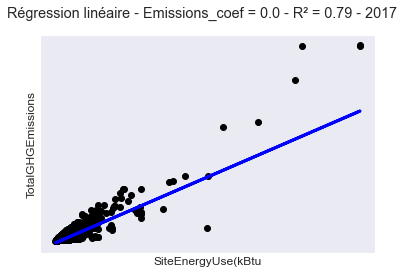




2016
Nombre de points: 2555 dont train: 1800
Coefficients: 
 [[2.74438456e-05]]
Erreur quadratique moyenne: 10018.70
Coefficient of determination: 0.83
Emissions coef save: 2.7443845572895914e-05
Coefficient Emissions: 0.000


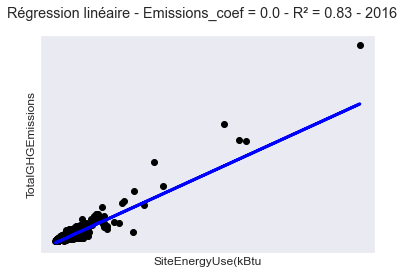




2015
Nombre de points: 2555 dont train: 1800
Coefficients: 
 [[2.70273887e-05]]
Erreur quadratique moyenne: 8721.85
Coefficient of determination: 0.77
Emissions coef save: 2.702738873111196e-05
Coefficient Emissions: 0.000


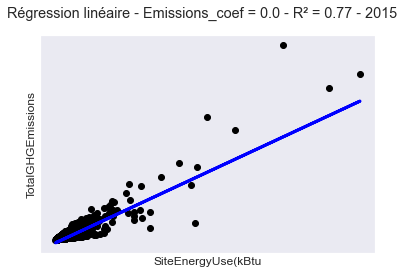




2018
Nombre de points: 2555 dont train: 1800
Coefficients: 
 [[2.10586051e-05]]
Erreur quadratique moyenne: 7581.21
Coefficient of determination: 0.77
Emissions coef save: 2.1058605052761197e-05
Coefficient Emissions: 0.000


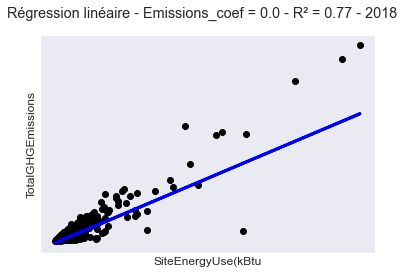




2019
Nombre de points: 2463 dont train: 1800
Coefficients: 
 [[2.40301898e-05]]
Erreur quadratique moyenne: 6365.63
Coefficient of determination: 0.79
Emissions coef save: 2.4030189767946422e-05
Coefficient Emissions: 0.000


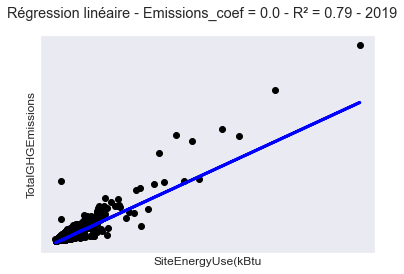

In [206]:
# années year_minus_1,year_minus_2,year_minus_3,year,year_plus_1:

Emissions_coef = {}

for data_year in [year_minus_1,year_minus_2,year_minus_3,year,year_plus_1]:
    
    # Création du dataframe filtré sur l'année
    df = data_fix_set[data_year].copy()
    df_year = df[df['DataYear'] == int(data_year)]
    
    # Passage de log() à exp() pour revenir aux valeurs d'origine
    df_year['SiteEnergyUse(kBtu)_bis'] = df_year['SiteEnergyUse(kBtu)'].apply(lambda x: np.power(10,x))
    df_year['TotalGHGEmissions_bis'] = df_year['TotalGHGEmissions'].apply(lambda x: np.power(10,x))
    
    # Split de l'entrée en training/testing sets
    energy_X_train = df_year['SiteEnergyUse(kBtu)_bis'][:-1800].values.reshape(-1, 1)
    energy_X_test = df_year['SiteEnergyUse(kBtu)_bis'][-1800:].values.reshape(-1, 1)

    # Split de la target en training/testing sets
    emissions_y_train = df_year['TotalGHGEmissions_bis'][:-1800].values.reshape(-1, 1)
    emissions_y_test = df_year['TotalGHGEmissions_bis'][-1800:].values.reshape(-1, 1)

    # Création d'objet de régression linéaire
    regr_GHG = linear_model.LinearRegression()

    # Entraînement du modèle utilisant le training set
    regr_GHG.fit(energy_X_train, emissions_y_train)

    # Prédictions à partir du set test
    emissions_y_pred = regr_GHG.predict(energy_X_test)
        
    # Année
    print("\n\n")
    print(int(data_year))
    
    # Nombre de points:
    print(f"Nombre de points: {df_year.shape[0]} dont train: 1800")
    
    # Les coeffcients
    print('Coefficients: \n', regr_GHG.coef_)
    
    # Erreur quadratique moyenne
    MSE = mean_squared_error(emissions_y_test, emissions_y_pred)
    print('Erreur quadratique moyenne: %.2f'
          % MSE)
    
    # Coefficient de determination: 1 est la prédiction parfaite
    R2 = r2_score(emissions_y_test, emissions_y_pred)
    print('Coefficient of determination: %.2f'
          % R2)

    Emissions_coef_save = regr_GHG.coef_[0][0]
    Emissions_coef[data_year] = round(Emissions_coef_save, 3)
    print(f"Emissions coef save: {Emissions_coef_save}")

    print('Coefficient Emissions: %.3f'
          % Emissions_coef[data_year]) 
    
    # Plot outputs
    plt.scatter(energy_X_test, emissions_y_test,  color='black')
    plt.plot(energy_X_test, emissions_y_pred, color='blue', linewidth=3)

    plt.xlabel('SiteEnergyUse(kBtu)')
    plt.ylabel('TotalGHGEmissions')
    plt.suptitle(f"Régression linéaire - Emissions_coef = {Emissions_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    
    # Sauvegarde
    file = int(data_year)
    plt.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{file}\\regression_energy_emissions_{file}.png", transparent=True)
    
    plt.show()


In [207]:
Emissions_coef

{'2017': 0.0, '2016': 0.0, '2015': 0.0, '2018': 0.0, '2019': 0.0}

## Calcul Emissions GHG - {year}

### Resconstruction de 'SiteEnergyUse(kBtu)' avec les parties a et b

In [208]:
# La target'SiteEnergyUse(kBtu)' doit être reconstruite en associant data_fix_set et data_fix_set_test[year] (a et b)
energy_target_year_predicted_df.shape[0]

2657

In [209]:
data_fix_set[year].shape[0] + data_fix_set_test[year].shape[0]

2657

In [210]:
# Création d'un datafarme avec les parties a et b de la target:
energy_target_year_a = pd.DataFrame(data_fix_set[year]['SiteEnergyUse(kBtu)'], columns=['SiteEnergyUse(kBtu)'])
energy_target_year_a

,SiteEnergyUse(kBtu)
0,6.873087
1,6.901075
2,7.828250
4,7.122606
6,6.772978
...,...
2968,6.113570
2970,6.173122
2971,7.227025
2972,5.903689


In [211]:
# Création d'un datafarme avec les parties a et b de la target:
energy_target_year_b = pd.DataFrame(data_fix_set_test[year]['SiteEnergyUse(kBtu)'], columns=['SiteEnergyUse(kBtu)'])
energy_target_year_b

,SiteEnergyUse(kBtu)
3,6.870766
33,8.764559
226,7.462285
227,7.537910
304,7.198523
...,...
2997,6.312811
2998,7.613012
2999,6.636734
3002,5.911765


In [212]:
energy_target_year = pd.concat([energy_target_year_a, energy_target_year_b])

In [213]:
energy_target_year.reset_index(drop=True, inplace=True)

In [214]:
energy_target_year

,SiteEnergyUse(kBtu)
0,6.873087
1,6.901075
2,7.828250
3,7.122606
4,6.772978
...,...
2652,6.312811
2653,7.613012
2654,6.636734
2655,5.911765


### Resconstruction de 'TotalGHGEmissions' avec les parties a et b

In [215]:
# Création d'un datafarme avec les parties a et b de la target:
emissions_target_year_a = pd.DataFrame(data_fix_set[year]['TotalGHGEmissions'], columns=['TotalGHGEmissions'])
emissions_target_year_a

,TotalGHGEmissions
0,2.293141
1,2.439017
2,3.115344
4,2.660771
6,2.255755
...,...
2968,0.544068
2970,1.408240
2971,2.574031
2972,0.322219


In [216]:
# Création d'un datafarme avec les parties a et b de la target:
emissions_target_year_b = pd.DataFrame(data_fix_set_test[year]['TotalGHGEmissions'], columns=['TotalGHGEmissions'])
emissions_target_year_b

,TotalGHGEmissions
3,2.412461
33,4.338753
226,1.879096
227,1.964260
304,2.636989
...,...
2997,0.732394
2998,2.913920
2999,2.028571
3002,1.220108


In [217]:
emissions_target_year = pd.concat([emissions_target_year_a, emissions_target_year_b])

In [218]:
emissions_target_year.reset_index(drop=True, inplace=True)

In [219]:
emissions_target_year

,TotalGHGEmissions
0,2.293141
1,2.439017
2,3.115344
3,2.660771
4,2.255755
...,...
2652,0.732394
2653,2.913920
2654,2.028571
2655,1.220108


### Vérification de corrélation entre énergie prédite et Emissions GHG

In [220]:
energy_target_year_predicted_df

,SiteEnergyUse(kBtu)_predicted_2018
0,6.583103
1,6.583103
2,7.534197
3,6.830821
4,6.411246
...,...
2652,6.583103
2653,7.127056
2654,6.830821
2655,6.105827


In [221]:
# Création d'un dataframe avec les 2 variables target réelle et prédite + Emmissions GHG:
year_d_frame = energy_target_year.copy()
year_d_frame[f'SiteEnergyUse(kBtu)_predicted_{year}'] = energy_target_year_predicted_df[f'SiteEnergyUse(kBtu)_predicted_{year}']
year_d_frame['TotalGHGEmissions'] = emissions_target_year['TotalGHGEmissions']
year_d_frame

,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)_predicted_2018,TotalGHGEmissions
0,6.873087,6.583103,2.293141
1,6.901075,6.583103,2.439017
2,7.828250,7.534197,3.115344
3,7.122606,6.830821,2.660771
4,6.772978,6.411246,2.255755
...,...,...,...
2652,6.312811,6.583103,0.732394
2653,7.613012,7.127056,2.913920
2654,6.636734,6.830821,2.028571
2655,5.911765,6.105827,1.220108


#### Corrélation de Pearson

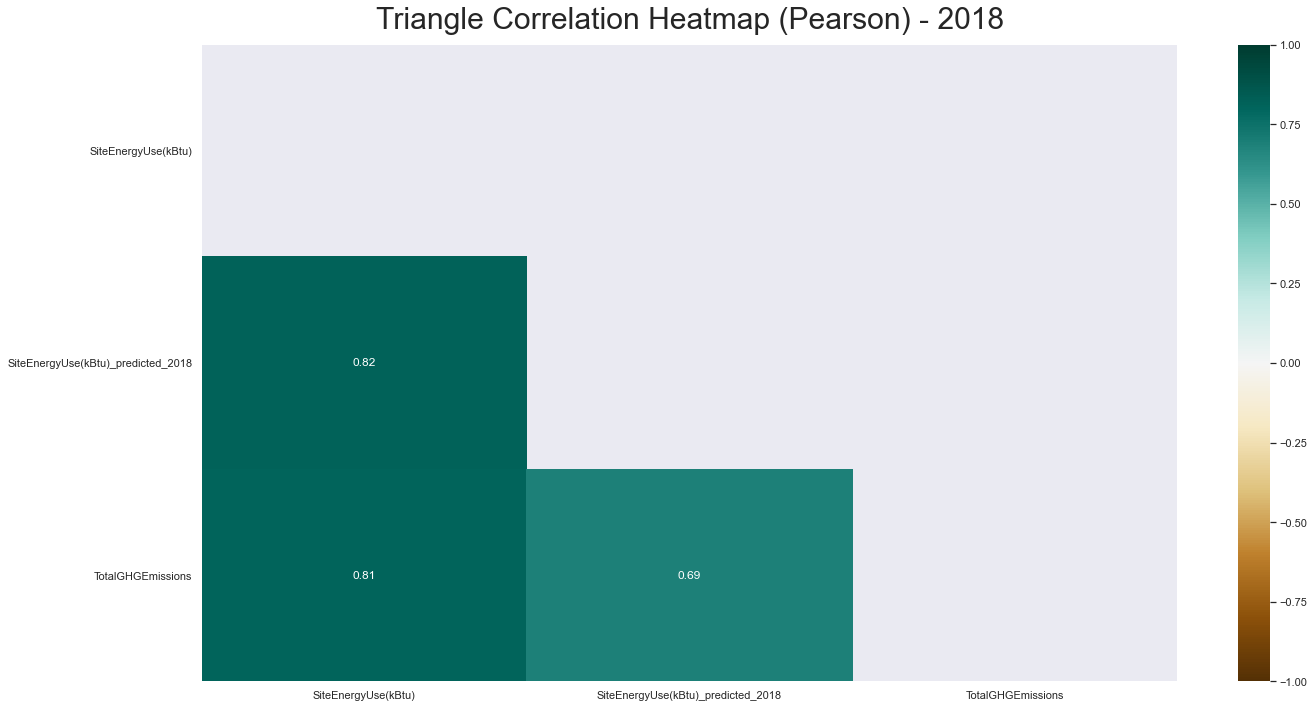

In [244]:
# Heatmap 
plt.figure(figsize=(20, 10))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(year_d_frame.corr()))
heatmap = sns.heatmap(year_d_frame.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title(f'Triangle Correlation Heatmap (Pearson) - {year}', fontdict={'fontsize':30}, pad=16);
plt.tight_layout()

fig = heatmap.get_figure()

# Sauvegarde
data_year = year
file = int(data_year)
plt.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{file}\\regression_energy_prédite_emissions_{file}.png", transparent=True)
    
plt.show()



On garde bien une corrélation ente l'énergie prédite et les émissions GHG




2018
Nombre de points: 2657 dont train: 1800
Coefficients: 
 [[1.14917073]]
Erreur quadratique moyenne: 0.32
Coefficient of determination: 0.45
Emissions coef save: 1.149170727944821
Coefficient Emissions: 1.149


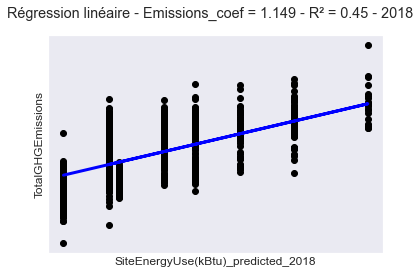

In [223]:
# annéeyear

Emissions_coef = {}

for data_year in [year]:
    
    # Création du dataframe filtré sur l'année
    df_year = year_d_frame.copy()
    
    # Split de l'entrée en training/testing sets
    energy_X_train = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][:-1800].values.reshape(-1, 1)
    energy_X_test = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][-1800:].values.reshape(-1, 1)

    # Split de la target en training/testing sets
    emissions_y_train = df_year['TotalGHGEmissions'][:-1800].values.reshape(-1, 1)
    emissions_y_test = df_year['TotalGHGEmissions'][-1800:].values.reshape(-1, 1)

    # Création d'objet de régression linéaire
    regr_GHG = linear_model.LinearRegression()

    # Entraînement du modèle utilisant le training set
    regr_GHG.fit(energy_X_train, emissions_y_train)

    # Prédictions à partir du set test
    emissions_y_pred = regr_GHG.predict(energy_X_test)
        
    # Année
    print("\n\n")
    print(int(data_year))
    
    # Nombre de points:
    print(f"Nombre de points: {df_year.shape[0]} dont train: 1800")
    
    # Les coeffcients
    print('Coefficients: \n', regr_GHG.coef_)
    
    # Erreur quadratique moyenne
    MSE = mean_squared_error(emissions_y_test, emissions_y_pred)
    print('Erreur quadratique moyenne: %.2f'
          % MSE)
    
    # Coefficient de determination: 1 est la prédiction parfaite
    R2 = r2_score(emissions_y_test, emissions_y_pred)
    print('Coefficient of determination: %.2f'
          % R2)

    Emissions_coef_save = regr_GHG.coef_[0][0]
    Emissions_coef[data_year] = round(Emissions_coef_save, 3)
    print(f"Emissions coef save: {Emissions_coef_save}")

    print('Coefficient Emissions: %.3f'
          % Emissions_coef[data_year]) 
    
    # Plot outputs
    plt.scatter(energy_X_test, emissions_y_test,  color='black')
    plt.plot(energy_X_test, emissions_y_pred, color='blue', linewidth=3)

    plt.xlabel(f'SiteEnergyUse(kBtu)_predicted_{year}')
    plt.ylabel('TotalGHGEmissions')
    plt.suptitle(f"Régression linéaire - Emissions_coef = {Emissions_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    
    # Sauvegarde
    file = int(data_year)
    plt.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{file}\\regression_energyWN_energy_{file}.png", transparent=True)
    
    plt.show()


### Resconstruction de 'energy_type_01' avec les parties a et b

In [224]:
# Création d'un datafarme avec les parties a et b:
type_energy_year_a = pd.DataFrame(data_fix_set[year]['energy_type_01'], columns=['energy_type_01'])
type_energy_year_a

,energy_type_01
0,electricity
1,gas
2,electricity
4,gas
6,gas
...,...
2968,electricity
2970,electricity
2971,electricity
2972,electricity


In [225]:
# Création d'un datafarme avec les parties a et b:
type_energy_year_b = pd.DataFrame(data_fix_set_test[year]['energy_type_01'], columns=['energy_type_01'])
type_energy_year_b

,energy_type_01
3,gas
33,gas
226,electricity
227,electricity
304,gas
...,...
2997,electricity
2998,electricity
2999,electricity
3002,electricity


In [226]:
type_energy_year = pd.concat([type_energy_year_a, type_energy_year_b])

In [227]:
type_energy_year.reset_index(drop=True, inplace=True)

In [228]:
type_energy_year

,energy_type_01
0,electricity
1,gas
2,electricity
3,gas
4,gas
...,...
2652,electricity
2653,electricity
2654,electricity
2655,electricity


In [229]:
# Modification du dataframe en ajoutant la variable:
year_d_frame['energy_type_01'] = type_energy_year['energy_type_01']
year_d_frame['energy_type_01'] = type_energy_year['energy_type_01']
year_d_frame

,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)_predicted_2018,TotalGHGEmissions,energy_type_01
0,6.873087,6.583103,2.293141,electricity
1,6.901075,6.583103,2.439017,gas
2,7.828250,7.534197,3.115344,electricity
3,7.122606,6.830821,2.660771,gas
4,6.772978,6.411246,2.255755,gas
...,...,...,...,...
2652,6.312811,6.583103,0.732394,electricity
2653,7.613012,7.127056,2.913920,electricity
2654,6.636734,6.830821,2.028571,electricity
2655,5.911765,6.105827,1.220108,electricity


In [230]:
# Filtre du dataframe en fonction du type d'énergie 'electricity'
electricity_year_d_frame = year_d_frame[year_d_frame['energy_type_01'] == 'electricity']
electricity_year_d_frame

,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)_predicted_2018,TotalGHGEmissions,energy_type_01
0,6.873087,6.583103,2.293141,electricity
2,7.828250,7.534197,3.115344,electricity
5,6.848586,6.583103,2.163460,electricity
7,6.759083,6.411246,2.219060,electricity
10,7.365274,7.127056,2.733679,electricity
...,...,...,...,...
2651,7.241325,7.127056,2.666892,electricity
2652,6.312811,6.583103,0.732394,electricity
2653,7.613012,7.127056,2.913920,electricity
2654,6.636734,6.830821,2.028571,electricity


In [231]:
# Filtre du dataframe en fonction du type d'énergie 'gas'
gas_year_d_frame = year_d_frame[year_d_frame['energy_type_01'] == 'gas']
gas_year_d_frame

,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)_predicted_2018,TotalGHGEmissions,energy_type_01
1,6.901075,6.583103,2.439017,gas
3,7.122606,6.830821,2.660771,gas
4,6.772978,6.411246,2.255755,gas
6,7.186735,6.830821,2.676145,gas
9,6.679179,6.411246,2.262925,gas
...,...,...,...,...
2624,6.902598,7.127056,2.437592,gas
2636,6.678484,6.411246,2.292256,gas
2647,6.544451,6.411246,2.056524,gas
2649,6.364166,6.105827,1.904716,gas


In [232]:
# Filtre du dataframe en fonction du type d'énergie 'steam'
steam_year_d_frame = year_d_frame[year_d_frame['energy_type_01'] == 'steam']
steam_year_d_frame

,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)_predicted_2018,TotalGHGEmissions,energy_type_01
8,7.205735,6.583103,2.744371,steam
11,6.994217,6.583103,2.545060,steam
57,7.316464,7.127056,2.741388,steam
117,8.367389,7.534197,3.822887,steam
124,6.825601,6.583103,2.321184,steam
143,6.531578,6.411246,2.030195,steam
146,7.223747,7.127056,2.675228,steam
192,7.729290,7.534197,3.218798,steam
202,7.521974,7.127056,3.037944,steam
212,6.698708,6.583103,2.192289,steam


#### Corrélation Emissions GHG/Energie par type d'énergie

##### 'electricity'

In [233]:
electricity_year_d_frame.shape

(2062, 4)




2018
Nombre de points: 2062 dont train: 1500
Coefficients: 
 [[1.15988757]]
Erreur quadratique moyenne: 0.22
Coefficient of determination: 0.55
Emissions coef save: 1.1598875666402184
Coefficient Emissions: 1.160


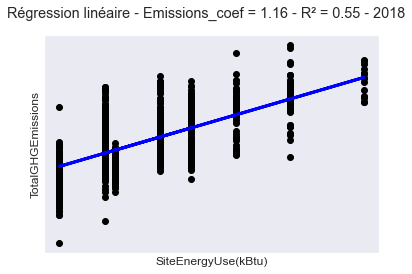

In [234]:
# année year

Emissions_coef = {}

for data_year in [year]:
    
    # Création du dataframe filtré sur l'année
    df_year = electricity_year_d_frame.copy()
    
    # Split de l'entrée en training/testing sets
    energy_X_train = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][:-1500].values.reshape(-1, 1)
    energy_X_test = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][-1500:].values.reshape(-1, 1)

    # Split de la target en training/testing sets
    emissions_y_train = df_year['TotalGHGEmissions'][:-1500].values.reshape(-1, 1)
    emissions_y_test = df_year['TotalGHGEmissions'][-1500:].values.reshape(-1, 1)

    # Création d'objet de régression linéaire
    regr_GHG = linear_model.LinearRegression()

    # Entraînement du modèle utilisant le training set
    regr_GHG.fit(energy_X_train, emissions_y_train)

    # Prédictions à partir du set test
    emissions_y_pred = regr_GHG.predict(energy_X_test)
        
    # Année
    print("\n\n")
    print(int(data_year))
    
    # Nombre de points:
    print(f"Nombre de points: {df_year.shape[0]} dont train: 1500")
    
    # Les coeffcients
    print('Coefficients: \n', regr_GHG.coef_)
    
    # Erreur quadratique moyenne
    MSE = mean_squared_error(emissions_y_test, emissions_y_pred)
    print('Erreur quadratique moyenne: %.2f'
          % MSE)
    
    # Coefficient de determination: 1 est la prédiction parfaite
    R2 = r2_score(emissions_y_test, emissions_y_pred)
    print('Coefficient of determination: %.2f'
          % R2)

    Emissions_coef_save = regr_GHG.coef_[0][0]
    Emissions_coef[data_year] = round(Emissions_coef_save, 3)
    print(f"Emissions coef save: {Emissions_coef_save}")

    print('Coefficient Emissions: %.3f'
          % Emissions_coef[data_year]) 
    
    # Plot outputs
    plt.scatter(energy_X_test, emissions_y_test,  color='black')
    plt.plot(energy_X_test, emissions_y_pred, color='blue', linewidth=3)

    plt.xlabel('SiteEnergyUse(kBtu)')
    plt.ylabel('TotalGHGEmissions')
    plt.suptitle(f"Régression linéaire - Emissions_coef = {Emissions_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    
    # Sauvegarde
    file = int(data_year)
    #plt.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{file}\\.png", transparent=True)
    
    plt.show()


##### 'gas'

In [235]:
gas_year_d_frame.shape

(562, 4)




2018
Nombre de points: 562 dont train: 400
Coefficients: 
 [[1.15218454]]
Erreur quadratique moyenne: 0.09
Coefficient of determination: 0.48
Emissions coef save: 1.1521845429819477
Coefficient Emissions: 1.152


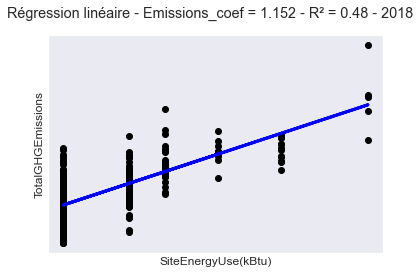

In [236]:
# année year

Emissions_coef = {}

for data_year in [year]:
    
    # Création du dataframe filtré sur l'année
    df_year = gas_year_d_frame.copy()
    
    # Split de l'entrée en training/testing sets
    energy_X_train = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][:-400].values.reshape(-1, 1)
    energy_X_test = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][-400:].values.reshape(-1, 1)

    # Split de la target en training/testing sets
    emissions_y_train = df_year['TotalGHGEmissions'][:-400].values.reshape(-1, 1)
    emissions_y_test = df_year['TotalGHGEmissions'][-400:].values.reshape(-1, 1)

    # Création d'objet de régression linéaire
    regr_GHG = linear_model.LinearRegression()

    # Entraînement du modèle utilisant le training set
    regr_GHG.fit(energy_X_train, emissions_y_train)

    # Prédictions à partir du set test
    emissions_y_pred = regr_GHG.predict(energy_X_test)
        
    # Année
    print("\n\n")
    print(int(data_year))
    
    # Nombre de points:
    print(f"Nombre de points: {df_year.shape[0]} dont train: 400")
    
    # Les coeffcients
    print('Coefficients: \n', regr_GHG.coef_)
    
    # Erreur quadratique moyenne
    MSE = mean_squared_error(emissions_y_test, emissions_y_pred)
    print('Erreur quadratique moyenne: %.2f'
          % MSE)
    
    # Coefficient de determination: 1 est la prédiction parfaite
    R2 = r2_score(emissions_y_test, emissions_y_pred)
    print('Coefficient of determination: %.2f'
          % R2)

    Emissions_coef_save = regr_GHG.coef_[0][0]
    Emissions_coef[data_year] = round(Emissions_coef_save, 3)
    print(f"Emissions coef save: {Emissions_coef_save}")

    print('Coefficient Emissions: %.3f'
          % Emissions_coef[data_year]) 
    
    # Plot outputs
    plt.scatter(energy_X_test, emissions_y_test,  color='black')
    plt.plot(energy_X_test, emissions_y_pred, color='blue', linewidth=3)

    plt.xlabel('SiteEnergyUse(kBtu)')
    plt.ylabel('TotalGHGEmissions')
    plt.suptitle(f"Régression linéaire - Emissions_coef = {Emissions_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    
    # Sauvegarde
    file = int(data_year)
    #plt.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{file}\\.png", transparent=True)
    
    plt.show()


##### 'steam'

In [237]:
steam_year_d_frame.shape

(33, 4)




2018
Nombre de points: 33 dont train: 20
Coefficients: 
 [[1.10872881]]
Erreur quadratique moyenne: 0.15
Coefficient of determination: 0.39
Emissions coef save: 1.1087288090448446
Coefficient Emissions: 1.109


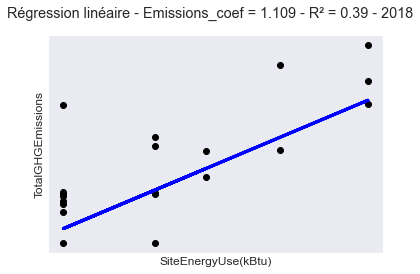

In [238]:
# année year

Emissions_coef = {}

for data_year in [year]:
    
    # Création du dataframe filtré sur l'année
    df_year = steam_year_d_frame.copy()
    
    # Split de l'entrée en training/testing sets
    energy_X_train = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][:-20].values.reshape(-1, 1)
    energy_X_test = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][-20:].values.reshape(-1, 1)

    # Split de la target en training/testing sets
    emissions_y_train = df_year['TotalGHGEmissions'][:-20].values.reshape(-1, 1)
    emissions_y_test = df_year['TotalGHGEmissions'][-20:].values.reshape(-1, 1)

    # Création d'objet de régression linéaire
    regr_GHG = linear_model.LinearRegression()

    # Entraînement du modèle utilisant le training set
    regr_GHG.fit(energy_X_train, emissions_y_train)

    # Prédictions à partir du set test
    emissions_y_pred = regr_GHG.predict(energy_X_test)
        
    # Année
    print("\n\n")
    print(int(data_year))
    
    # Nombre de points:
    print(f"Nombre de points: {df_year.shape[0]} dont train: 20")
    
    # Les coeffcients
    print('Coefficients: \n', regr_GHG.coef_)
    
    # Erreur quadratique moyenne
    MSE = mean_squared_error(emissions_y_test, emissions_y_pred)
    print('Erreur quadratique moyenne: %.2f'
          % MSE)
    
    # Coefficient de determination: 1 est la prédiction parfaite
    R2 = r2_score(emissions_y_test, emissions_y_pred)
    print('Coefficient of determination: %.2f'
          % R2)

    Emissions_coef_save = regr_GHG.coef_[0][0]
    Emissions_coef[data_year] = round(Emissions_coef_save, 3)
    print(f"Emissions coef save: {Emissions_coef_save}")

    print('Coefficient Emissions: %.3f'
          % Emissions_coef[data_year]) 
    
    # Plot outputs
    plt.scatter(energy_X_test, emissions_y_test,  color='black')
    plt.plot(energy_X_test, emissions_y_pred, color='blue', linewidth=3)

    plt.xlabel('SiteEnergyUse(kBtu)')
    plt.ylabel('TotalGHGEmissions')
    plt.suptitle(f"Régression linéaire - Emissions_coef = {Emissions_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    
    # Sauvegarde
    file = int(data_year)
    #plt.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{file}\\.png", transparent=True)
    
    plt.show()


Le coefficient de détermination est trop faible, une autre méthode doit être trouvée pour prédire les émissions GHG à partir de l'énergie prédite

# EXPORT DATASET MODIFIE - CSV